# Seurat - Guided Clustering Tutorial Using PBMC Data

## Overview
This is a standard unsupervised clustering workflow including QC and data filtration, calculation of high-variance genes, dimensional reduction, graph-based clustering and identification of cluster markers on Peripheral Blood Mononuclear Cells (PBMCs) made publicly available by 10X Genomics.

## Dataset
- Peripheral Blood Mononuclear Cells (PBMC) freely available from 10X Genomics.
- 2700 single cells sequenced on the Illumina NextSeq 500.

In [1]:
untar("data/pbmc3k_filtered_gene_bc_matrices.tar.gz", exdir="data")

- ```Read10X()```: reads in the output of the cellranger pipeline from 10X, returning a unique molecular identified (UMI) count matrix.
- Rows: genes; Columns: cells
- Each value in the matrix represent the number of molecules for each feature (gene) that are detected in each cell.

In [2]:
library(dplyr)
library(Seurat)
library(patchwork)
library(ggplot2)

# Load the PBMS dataset
pbmc.data <- Read10X(data.dir = "./data/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object witht the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

In [3]:
# Adjust plot size
options(repr.plot.width=15, repr.plot.height=10)

In [4]:
# Row names: names of each feature/gene.
# Column names: names of each cell

pbmc.data[c("CD3D","TCL1A","MS4A1"), 1:30]

# The matrix is represented as a sparse matrix whenever possible since most values in an scRNA-seq matrix are 0.

  [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

In [5]:
dense.size <- object.size(as.matrix(pbmc.data))
dense.size

709591472 bytes

In [6]:
sparse.size <- object.size(pbmc.data)
sparse.size

29905192 bytes

In [7]:
dense.size/sparse.size

23.7 bytes

## Standard pre-processing workflow
The steps below encompass the standard pre-processing workflow for scRNA-seq data in Seurat:
1. Selection and filtration of cells based on QC metrics
2. Data normalization and scaling
3. Detection of highly variable features

### QC and selecting cells for further analysis

QC (Quality Control) metrics can be explored and cells can be filtered on any user-defined criteria. QC metrics are stored in the object metadata.

#### QC metrics commonly used by the community:
* Number of unique genes detected in each cell.
  * Low-quality cells or empty droplets will often have very few genes
  * Cell doublets or multiplets may exhibit an aberrantly high gene count
  * This is automatically calculated and stored in the object metadata during ```CreateSeuratObject()```
* Total number of molecules detected within a cell (correlates strongly with unique genes)
  * This is automatically calculated and stored in the object metadata during ```CreateSeuratObject()```
* Percentage of reads that map to the mitochondrial genome
  * Low-quality/dying cells often exhibit extensive mitochondrial contamination
  * Since the percentage of reads that map to the mitochondrial gene are not readily available to the data, we will add it manually
      1. We calculate mitochondrial QC metrics with the ```PercentageFeatureSet()``` function, which calculates the percentage of counts originating from a set of features.
      2. We use the set of all genes starting with ```MT-``` as a set of mitochondrial genes
      3. We will name the result ```percent.mt``` and add it to the ojbect metadata.

In [8]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

In [9]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

orig.ident nCount_RNA nFeature_RNA percent.mt
AAACATACAACCAC-1 pbmc3k     2419        779         3.0177759 
AAACATTGAGCTAC-1 pbmc3k     4903       1352         3.7935958 
AAACATTGATCAGC-1 pbmc3k     3147       1129         0.8897363 
AAACCGTGCTTCCG-1 pbmc3k     2639        960         1.7430845 
AAACCGTGTATGCG-1 pbmc3k      980        521         1.2244898

We visualise the the QC metrics and use the insights to filter the cells.

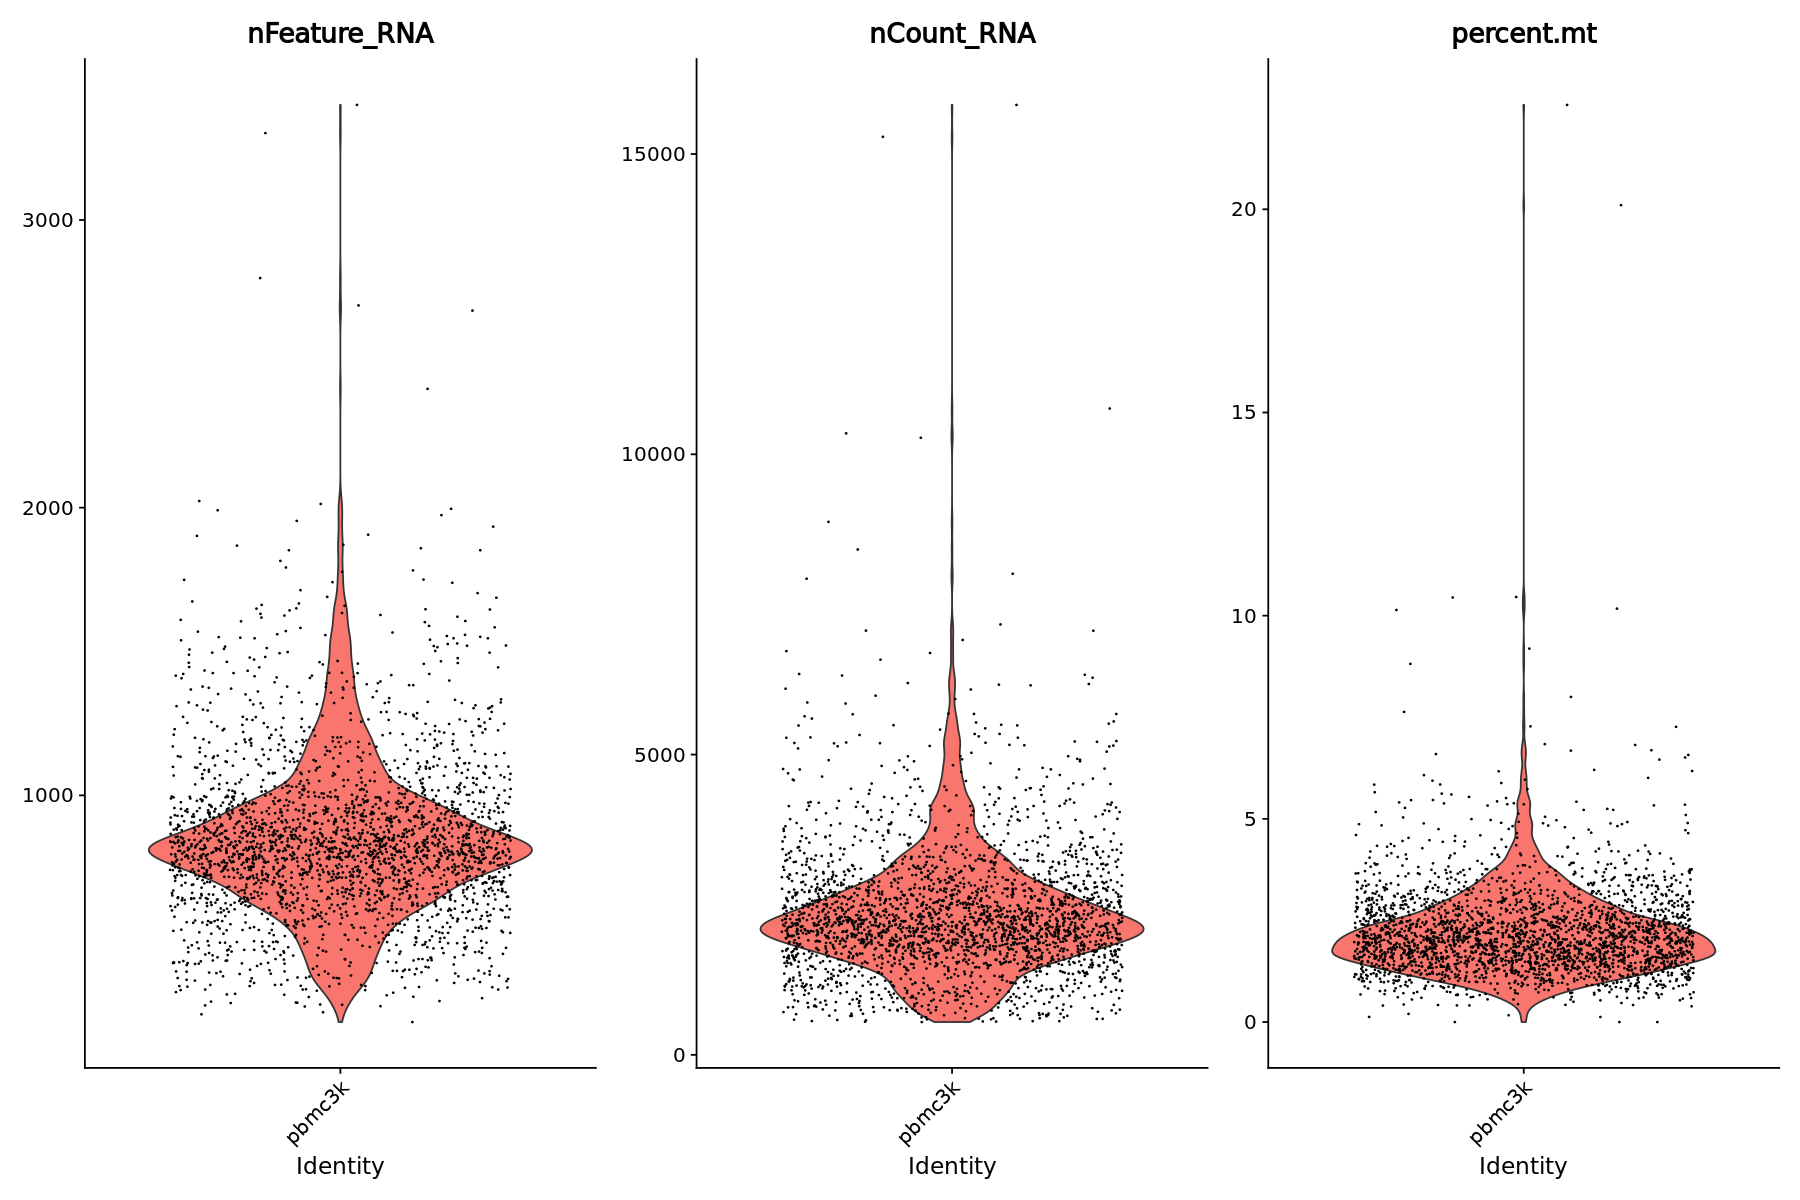

In [10]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

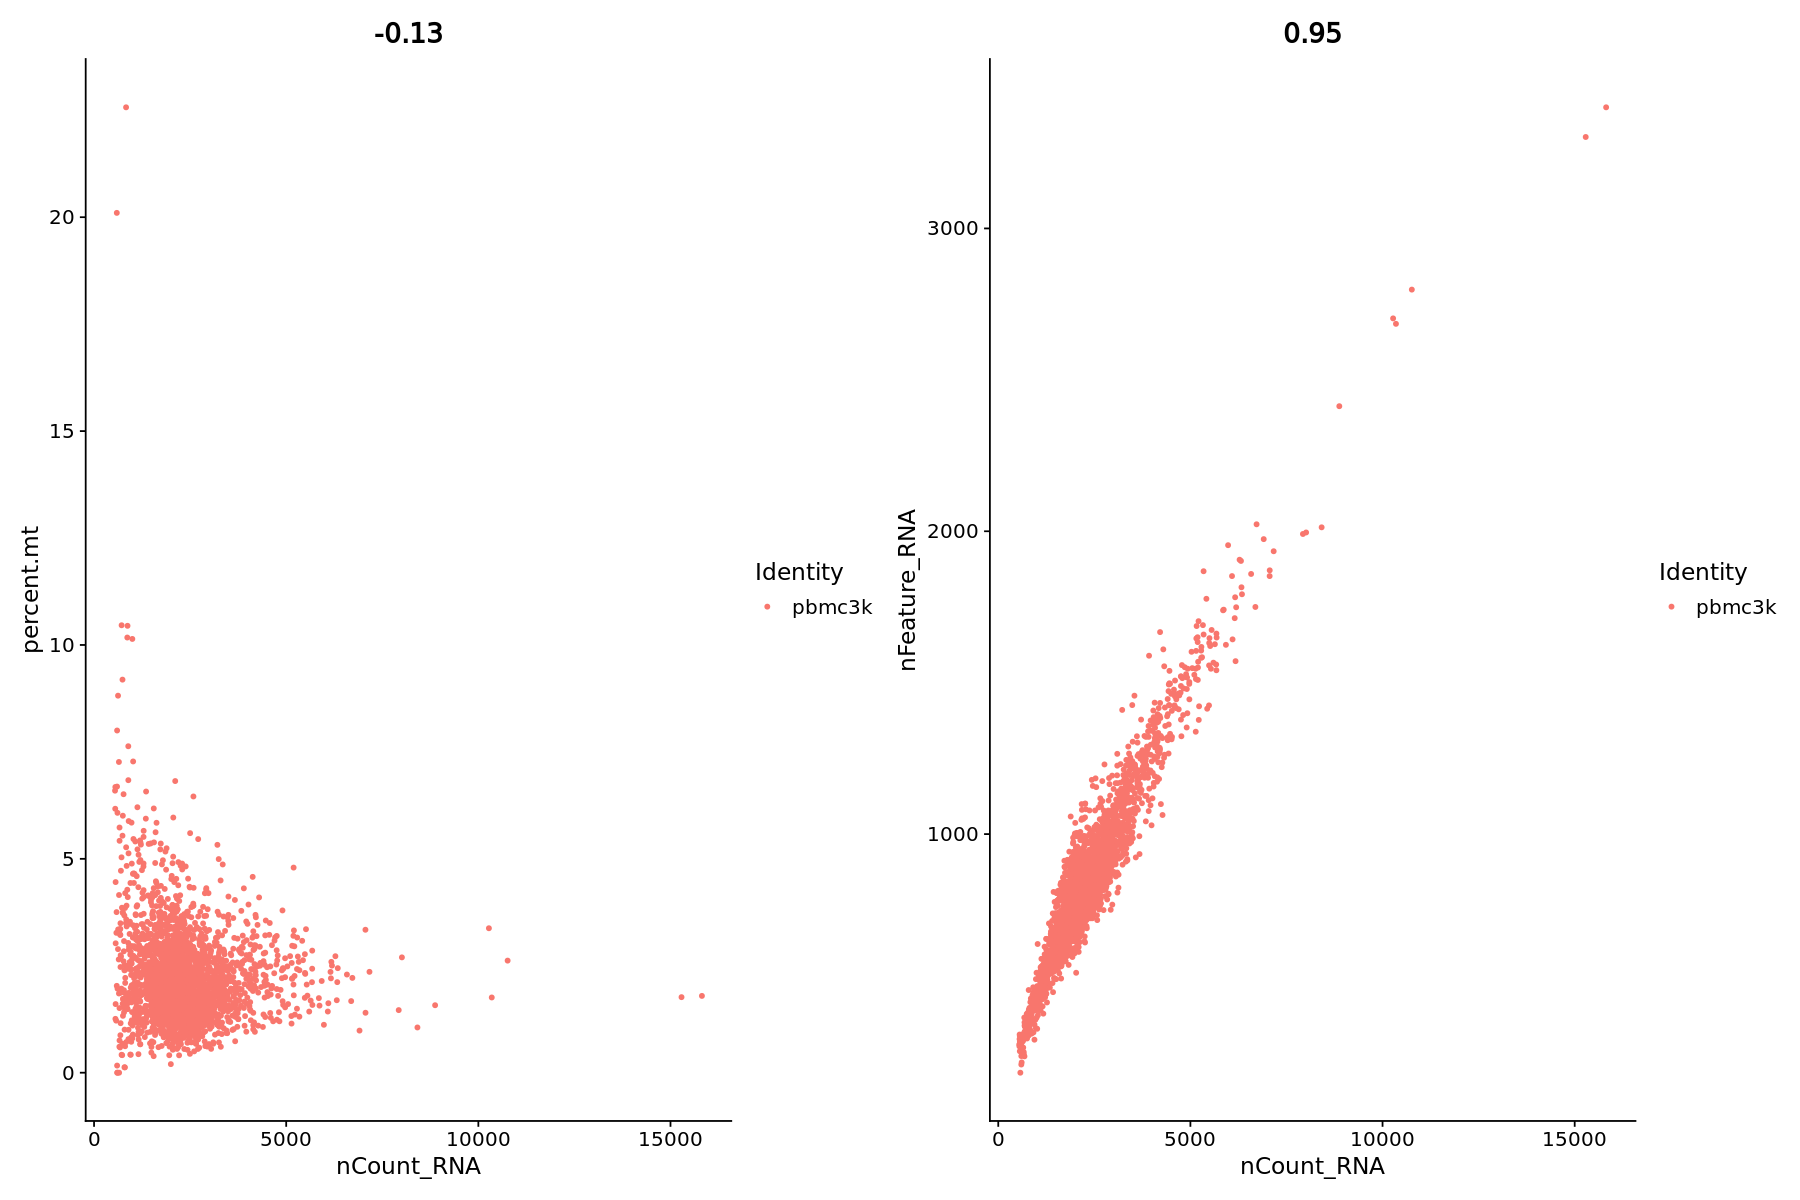

In [11]:
# FeatureScatter is typically used  to visualize feature-feature relationships, but can be used for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

We will filter based on the following:
* High-quality cells have nFeature_RNA within 200 and 2500.
* High-quality cells have percent.mt < 5.

In [12]:
pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

We repeat the visualization to check if refinements are needed.

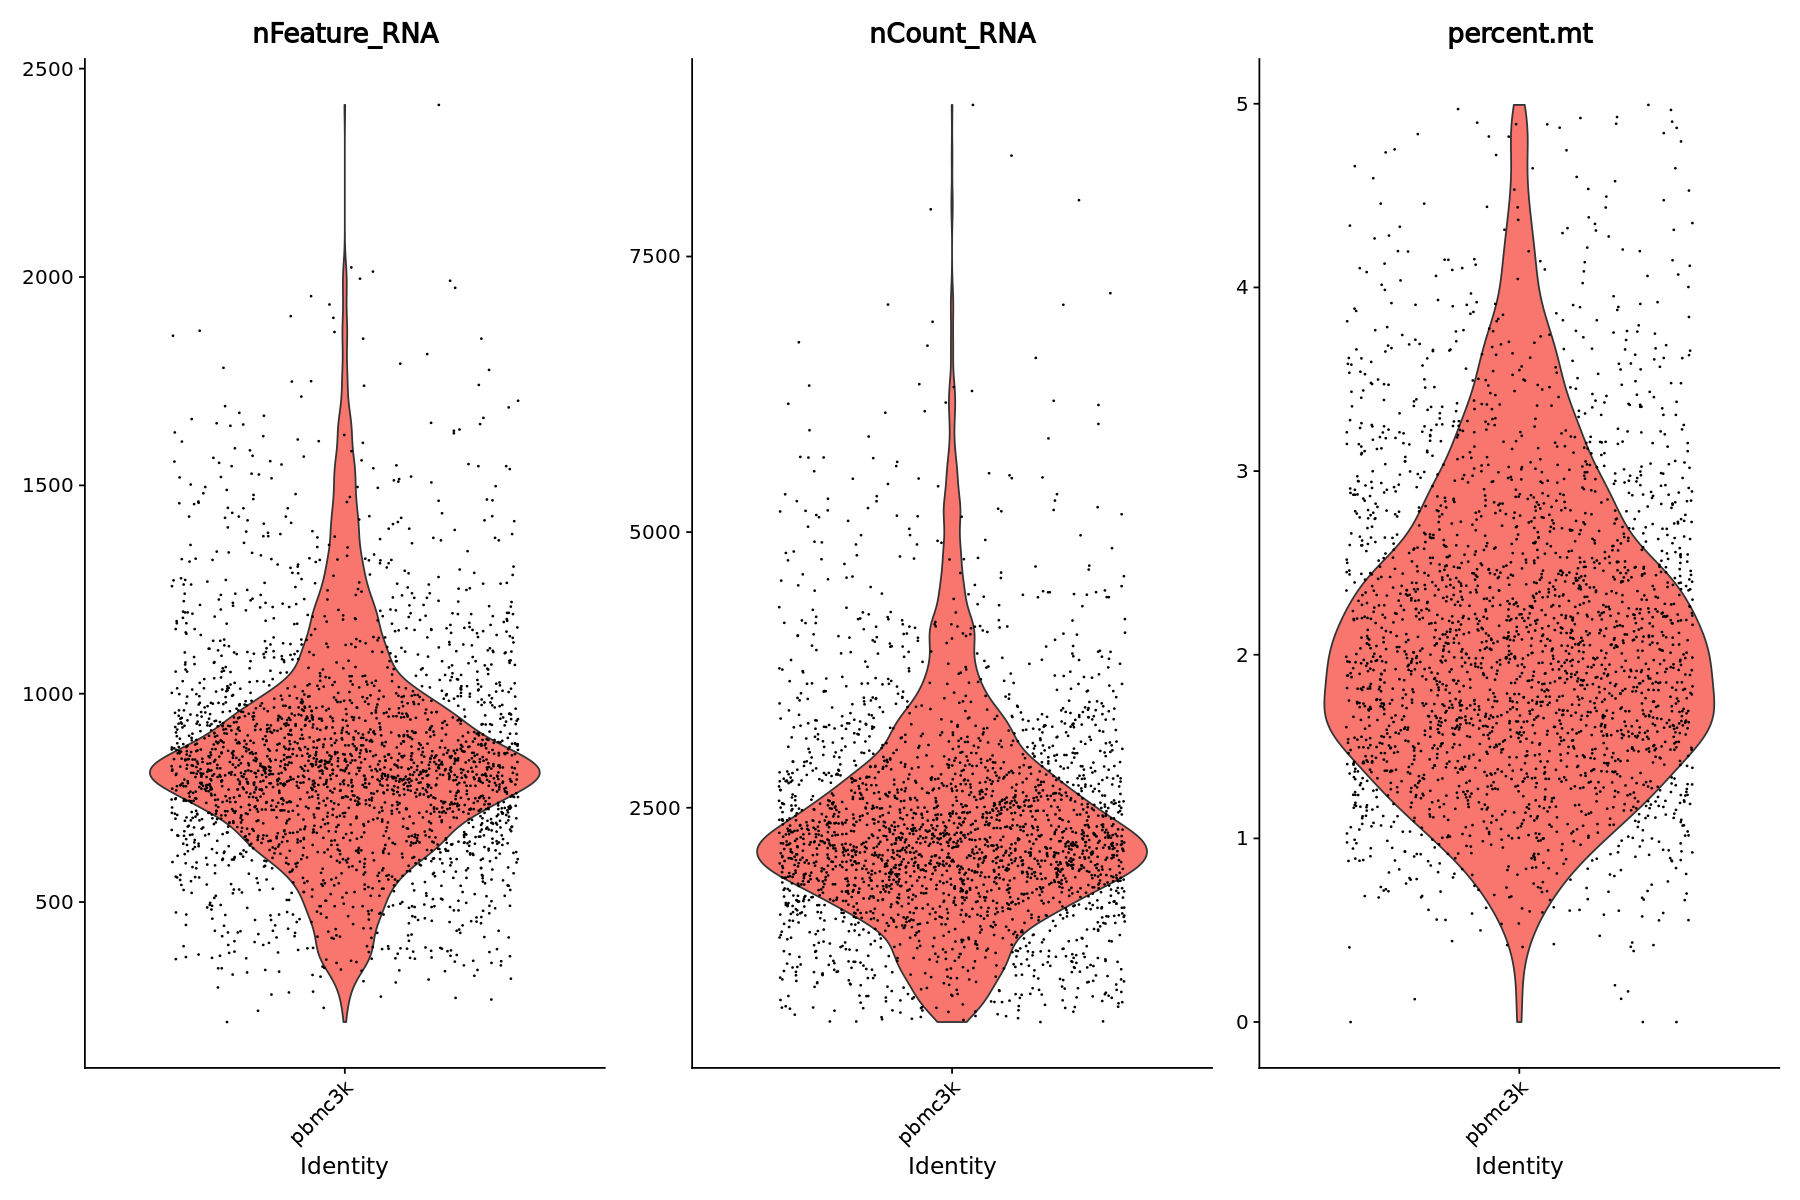

In [13]:
# Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

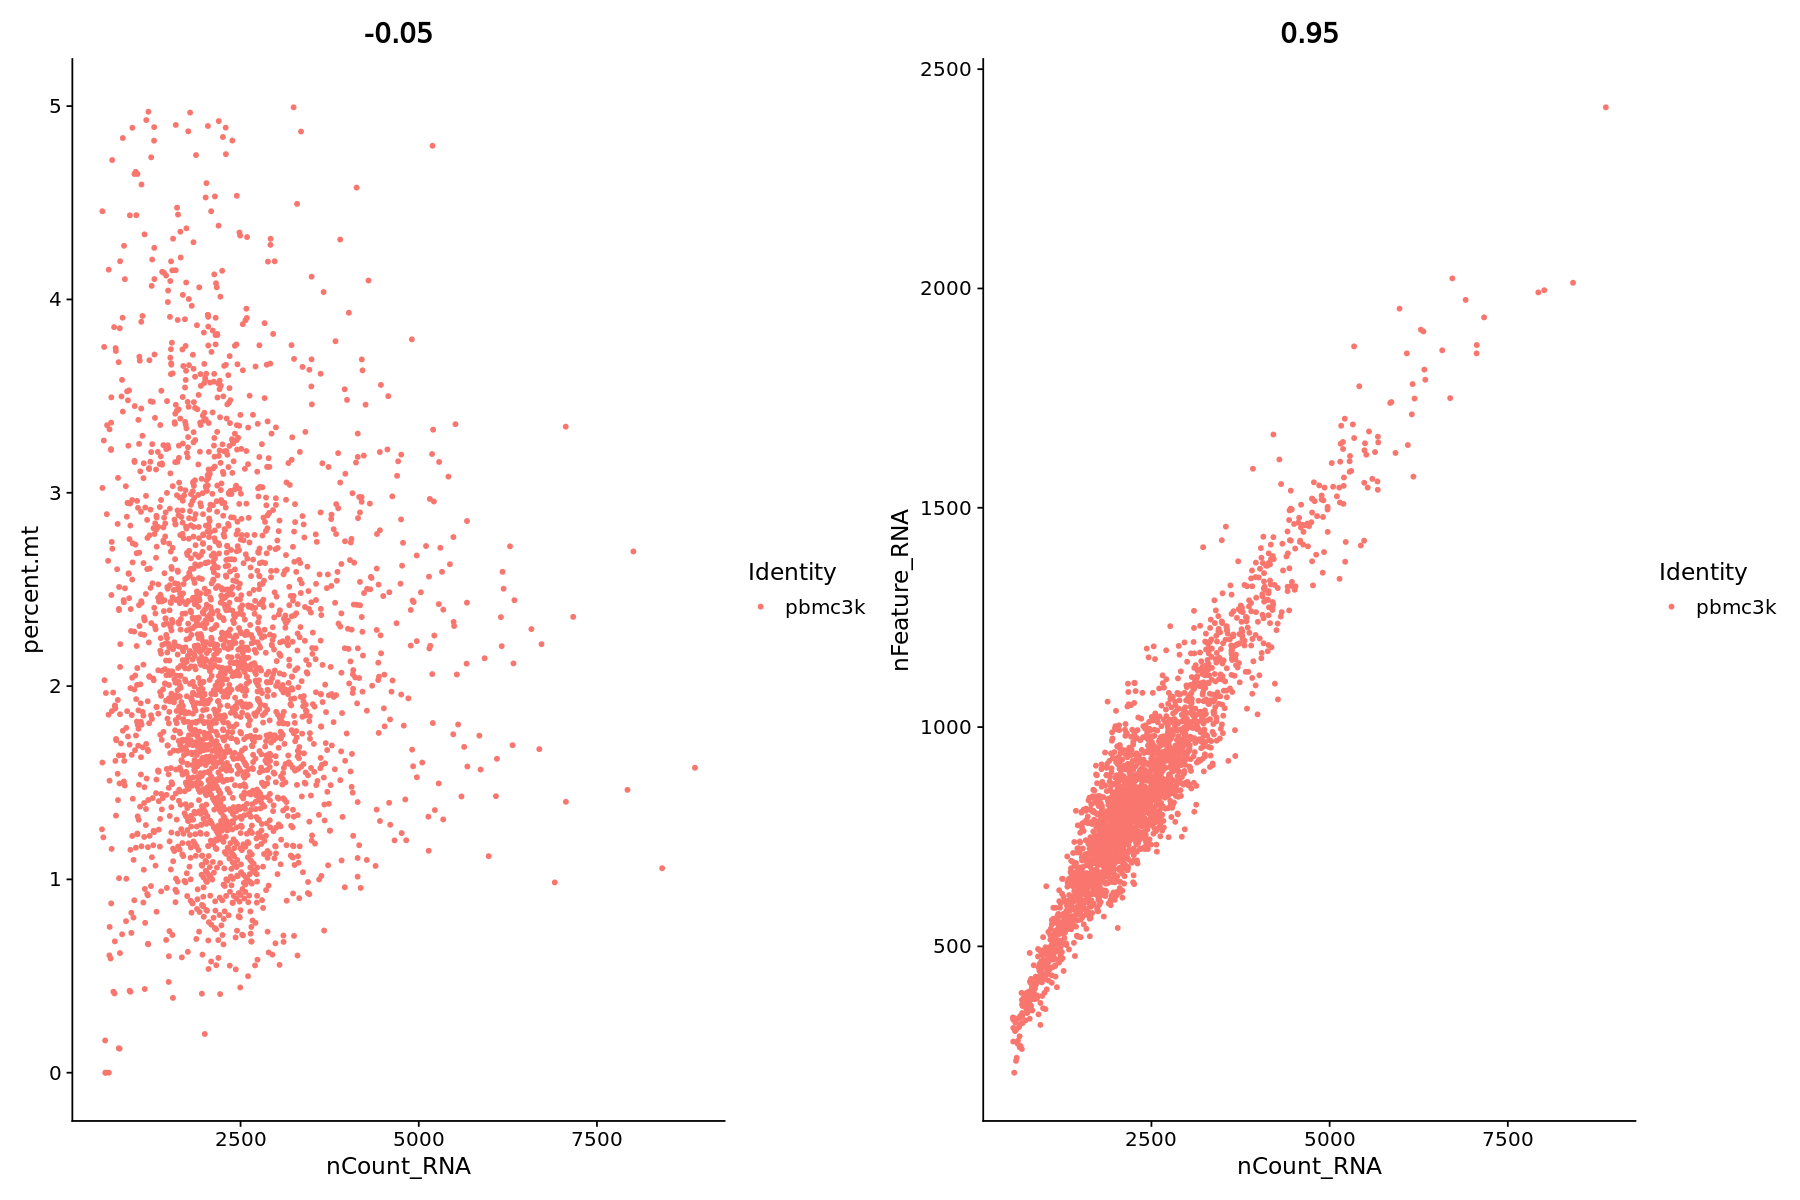

In [14]:
plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt")
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA")
plot1 + plot2

At this point, low quality cells have already been filtered.

### Normalizing the data

By default, data is normalized by using a global-scaling normalization method "LogNormalize".
1. The feature expression measurements for each cell is normalized by the total expression.
2. Normalized value is multiplied by a scale factore (default: 10000).
3. Result is log-transformed.
4. Normalized values are stored in ```pbmc[["RNA"]]@data```.

In [15]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 10000)

Since the parameters are default values, this can also be achieved by
```R
pbmc <- NormalizeData(pbmc)
```

### Identification of highly variable features (feature selection)

Calculate a subset of features that exhibit **high cell-to-cell variation** in the dataset (i.e., they are highly expressed in some cells, and lowly expressed in others).
* Focusing on these genes helps to highlight biological signal in single-cell datasets.
* Implemented in Seurat using ```FindVariableFeatures()```.
  * By default, 2000 features are returned per dataset. In this tutorial, only 10 features will be returned.
* The resulting features will be used in downstream analysis like PCA.

In [16]:
pbmc <- FindVariableFeatures(pbmc, selection.method = "vst", nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

Warning message:
“Transformation introduced infinite values in continuous x-axis”


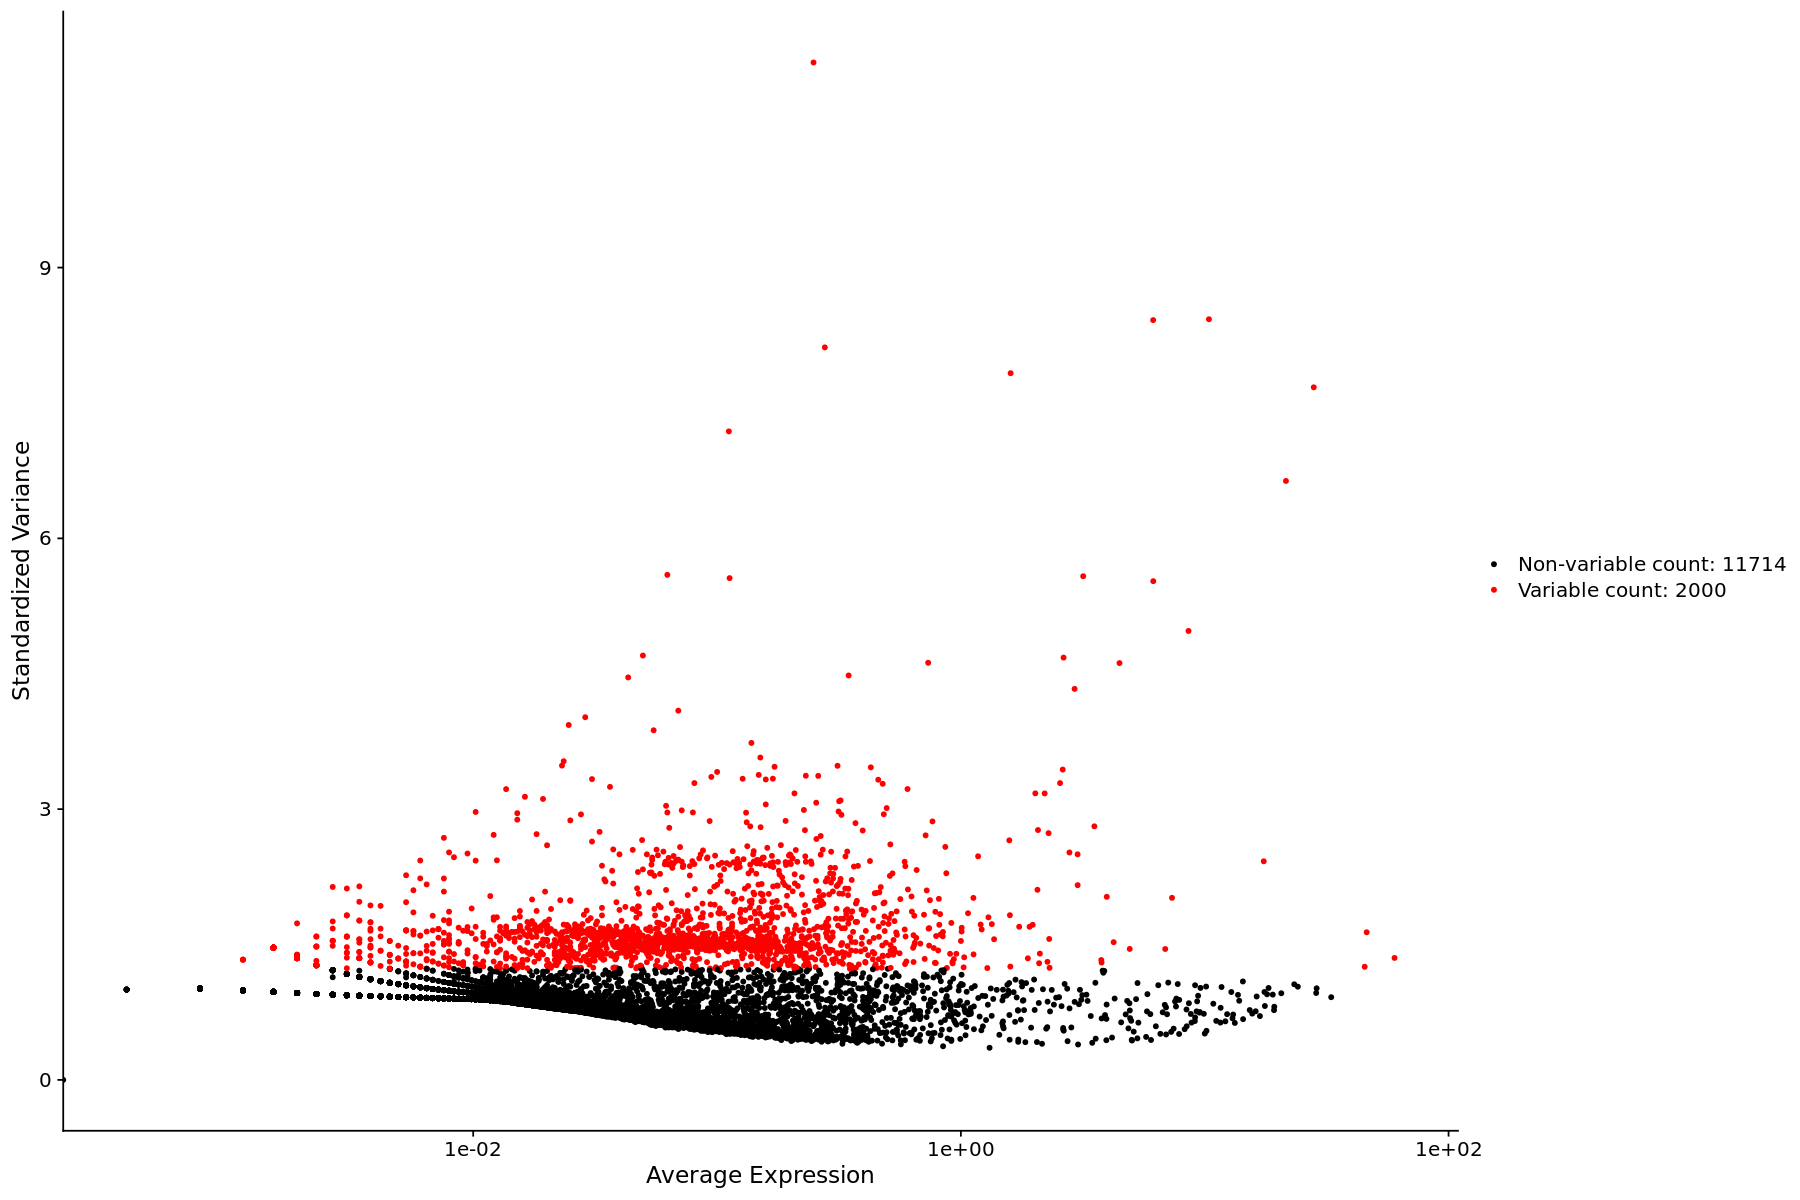

In [17]:
# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, xnudge = 0, ynudge = 0, repel = TRUE)

# For now, only plot 1 will be displayed. Displaying plot1 and plot2 at the same time results to errors.
plot1

Warning message:
“Transformation introduced infinite values in continuous x-axis”


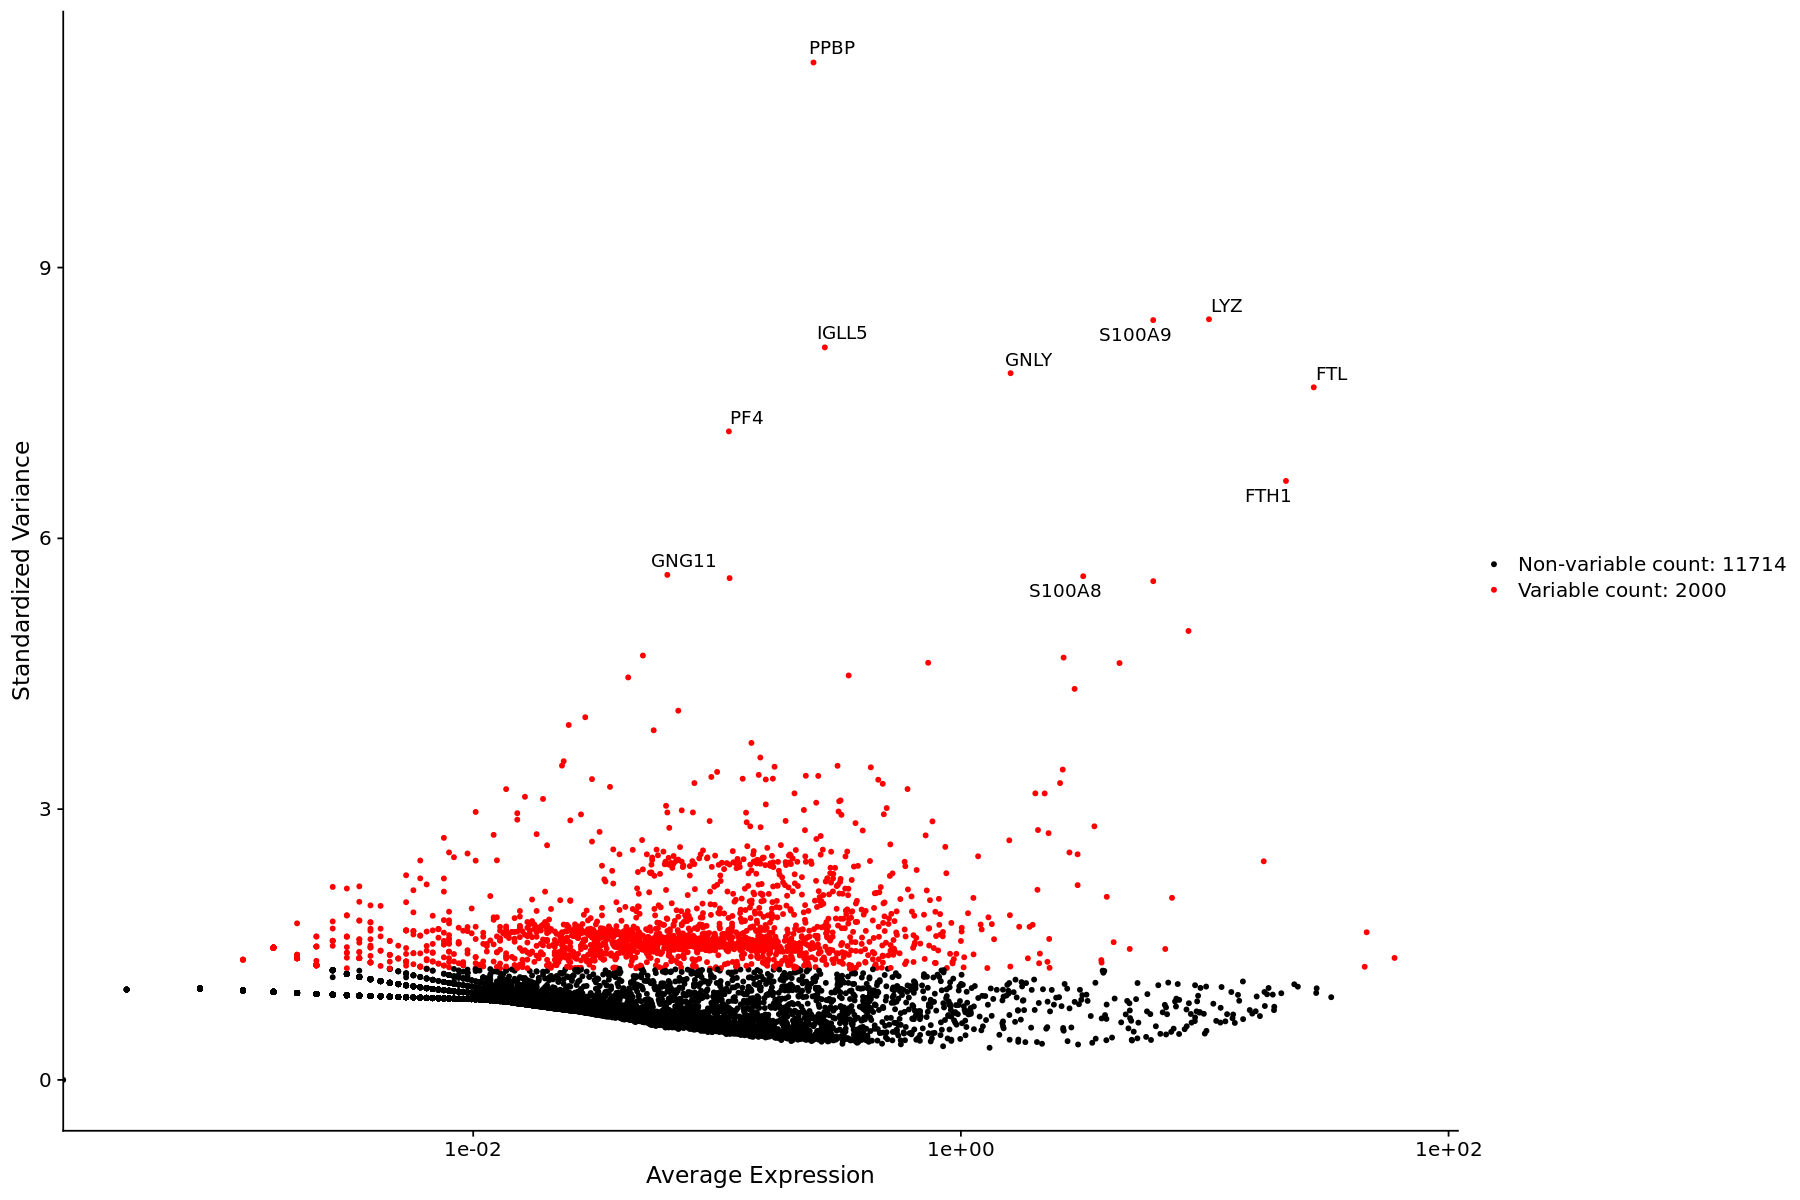

In [18]:
plot2

### Scaling the Data
We apply scaling prior to dimensional reduction. The goal is for each feature to have a mean
expression of 0 and a variance of 1. 
* We do this so that highly-expressed genes do not dominate.
* We use the ```ScaleData()``` function.
  * The results are stored in ```pbmc[["RNA"]]@scale.data```

Only the features that have high cell-to-cell variation are needed to be scaled, However, to avoid highly-expressed genes dominating the heatmaps, all genes are considered during scaling. This takes a long time.

To perform scaling only on the highly-variable features, scaling can be performed by executing this instead.
```R
pbmc <- ScaleData(pbmc)
```

In ```Seurat v2``` the ```ScaleData()``` function can also be used to remove unwanted sources of variation from a single-cell dataset. For example, we could `regress out' heterogeneity associated with (for example) cell cycle stage, or mitochondrial contamination. These features are still supported in ```ScaleData()``` in ```Seurat v3```, i.e.:
```R
pbmc <- ScaleData(pbmc, vars.to.regress = "percent.mt")
```
However, it is strongly recommended that the new normalization workflow, ```SCTransform()``` be used. As with ```ScaleData()``` the function ```SCTransform()``` also includes a ```vars.to.regress``` parameter.

In [19]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



### Perform Linear Dimensional Reduction


Perform Principal Component Analysis (PCA) on the highly variable features to determine the primary sources of heterogeneity.
```R
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))
```
Here, the ```features``` argument is used to indicate that only the previously determined variable features are used as input. However, a different subset of features can be used by setting ```features``` to a different value.

In [20]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, S100A8, CTSS, LGALS2, SERPINA1, IFITM3, SPI1, CFP 
	   PSAP, IFI30, SAT1, COTL1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CD27, STK17A, CTSW 
	   CD247, GIMAP5, AQP3, CCL5, SELL, TRAF3IP3, GZMA, MAL, CST7, ITM2A 
	   MYC, GIMAP7, HOPX, BEX2, LDLRAP1, GZMK, ETS1, ZAP70, TNFAIP8, RIC3 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, APMAP, CTSC, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1, HLA-DPA

Seurat provides useful ways of visualizing both cells and features that define the PCA:
* ```VizDimLoadings()```
* ```DimPlot()```
* ```DimHeatmap()```

In [21]:
# Examine and visualize PCA results a few different ways
print(pbmc[["pca"]], dims = 1:5, nfeatures = 5)

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMB, GZMA 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPB1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, IL32, S100A8 
PC_ 5 
Positive:  GZMB, NKG7, S100A8, FGFBP2, GNLY 
Negative:  LTB, IL7R, CKB, VIM, MS4A7 


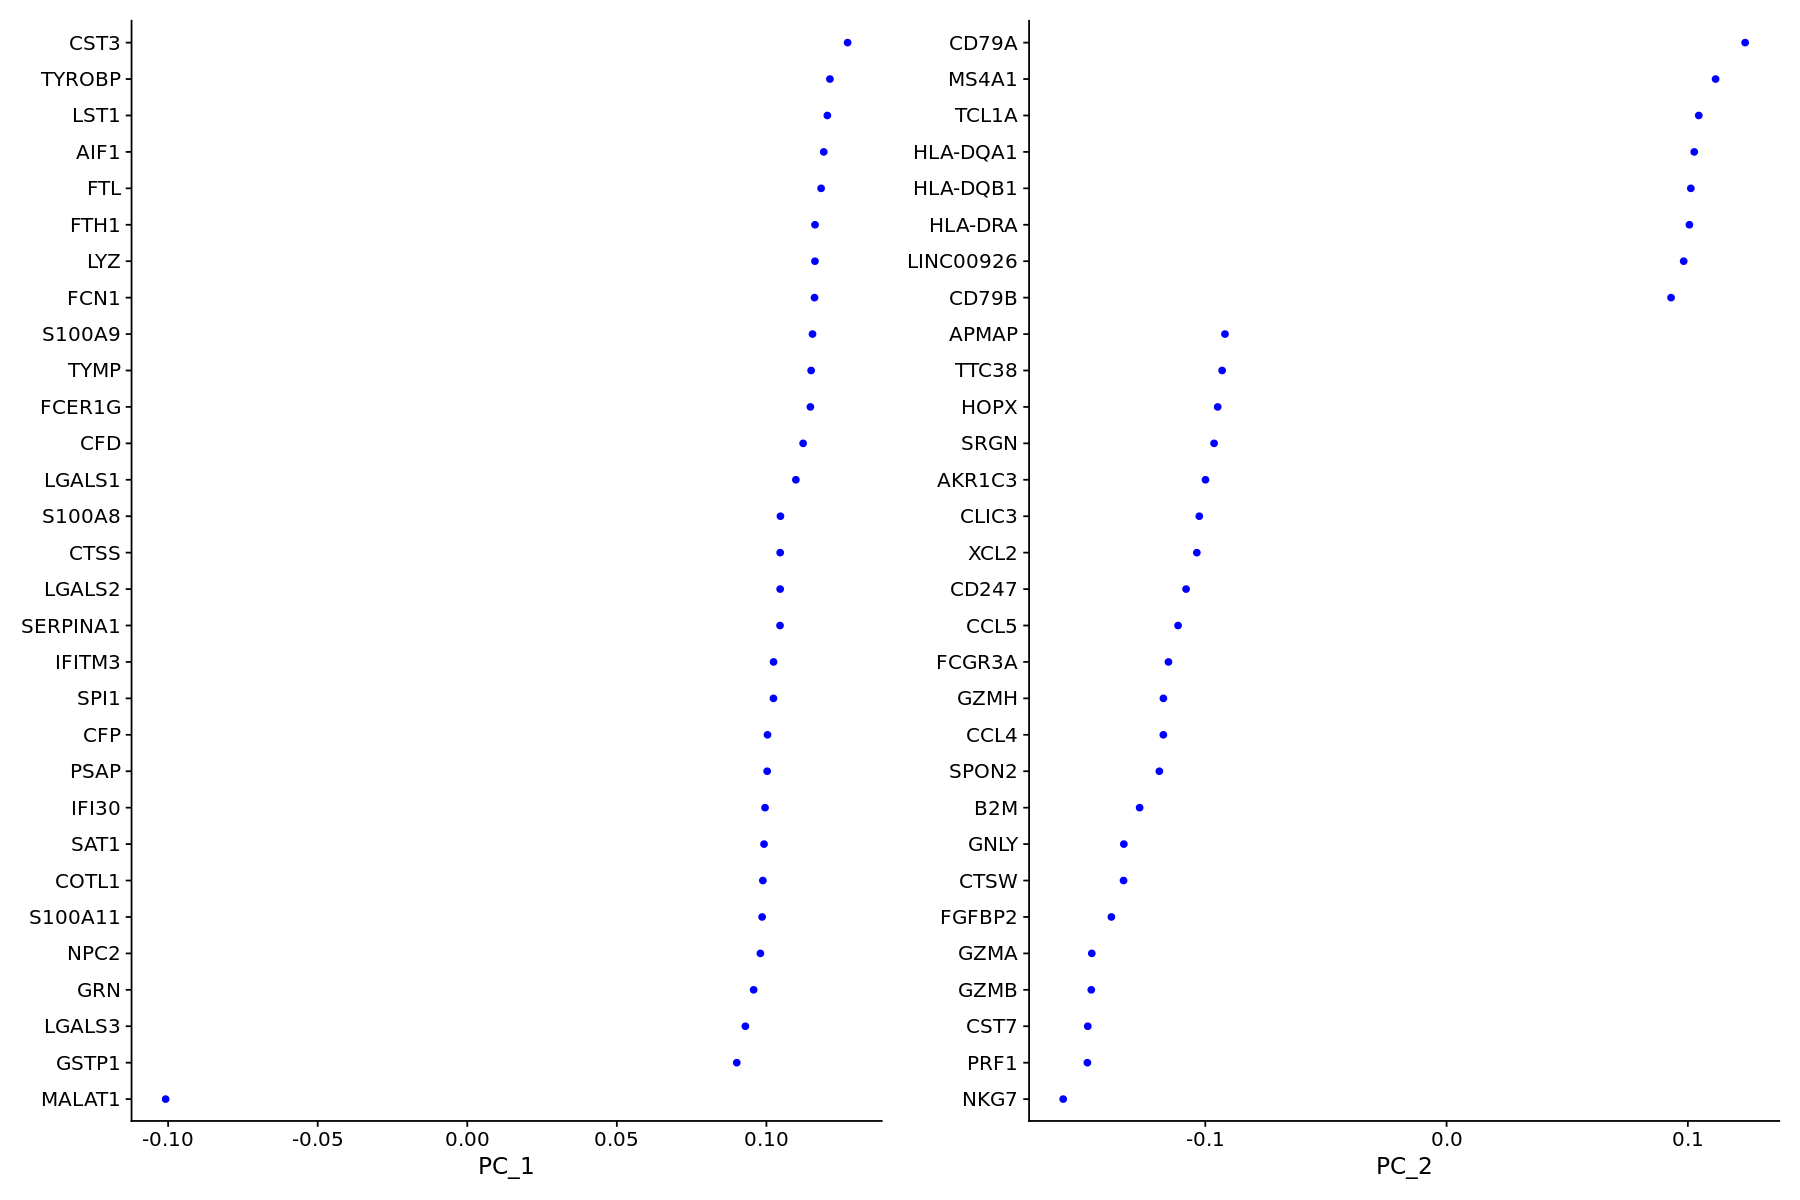

In [22]:
VizDimLoadings(pbmc, dims = 1:2, reduction = "pca")

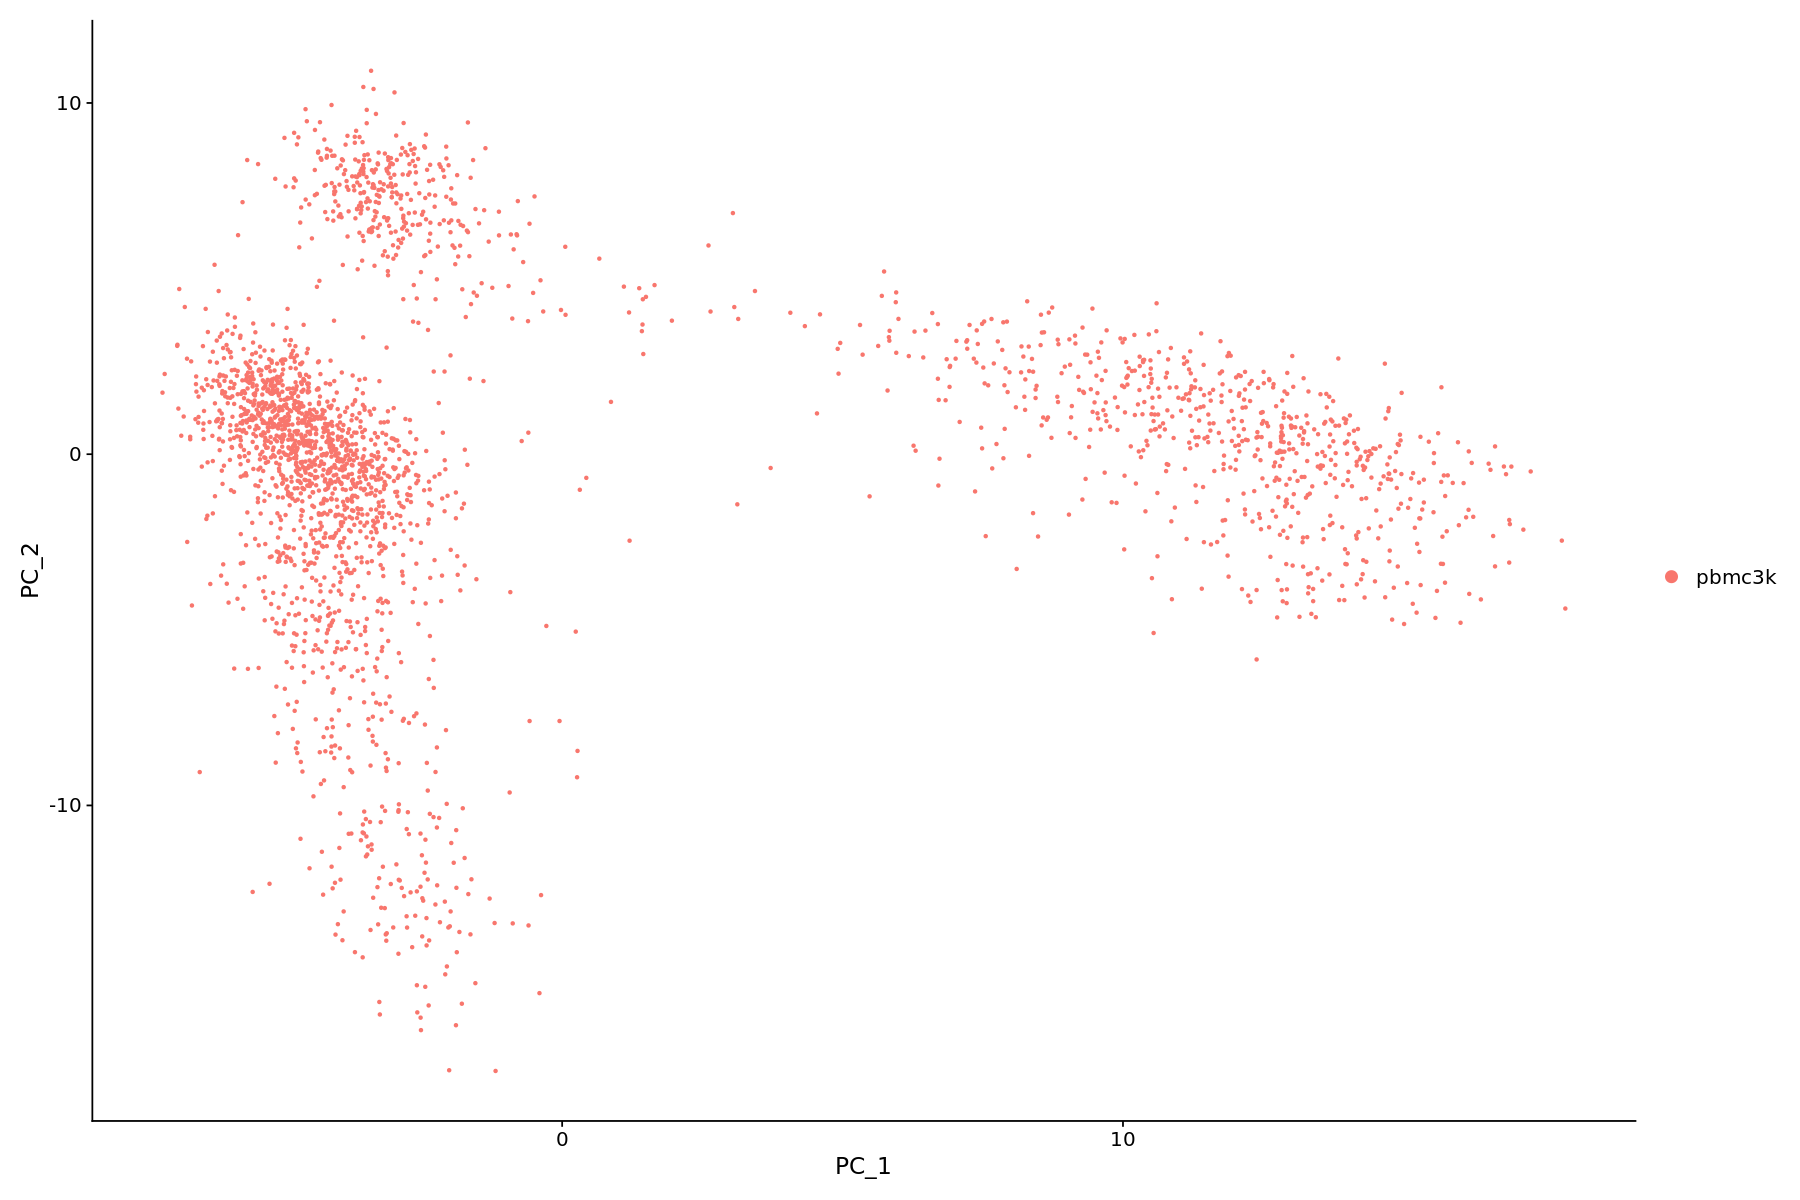

In [23]:
DimPlot(pbmc, reduction = "pca")

```DimHeatmap()``` - allows for easy exploration of the primary sources of heterogeneity in a dataset. It **can be useful when trying to decide which PCs to include for further downstream analyses**. This is a valuable tool for exploring correlated features sets even though it is clearly a supervised analysis.
* ```dims``` - number of dimensions (i.e. principal components) to show
* ```cells``` - number of extreme cells (on both sides of  the spectrum) to include in the plot.
Both cells and features are ordered according to their PCA scores.

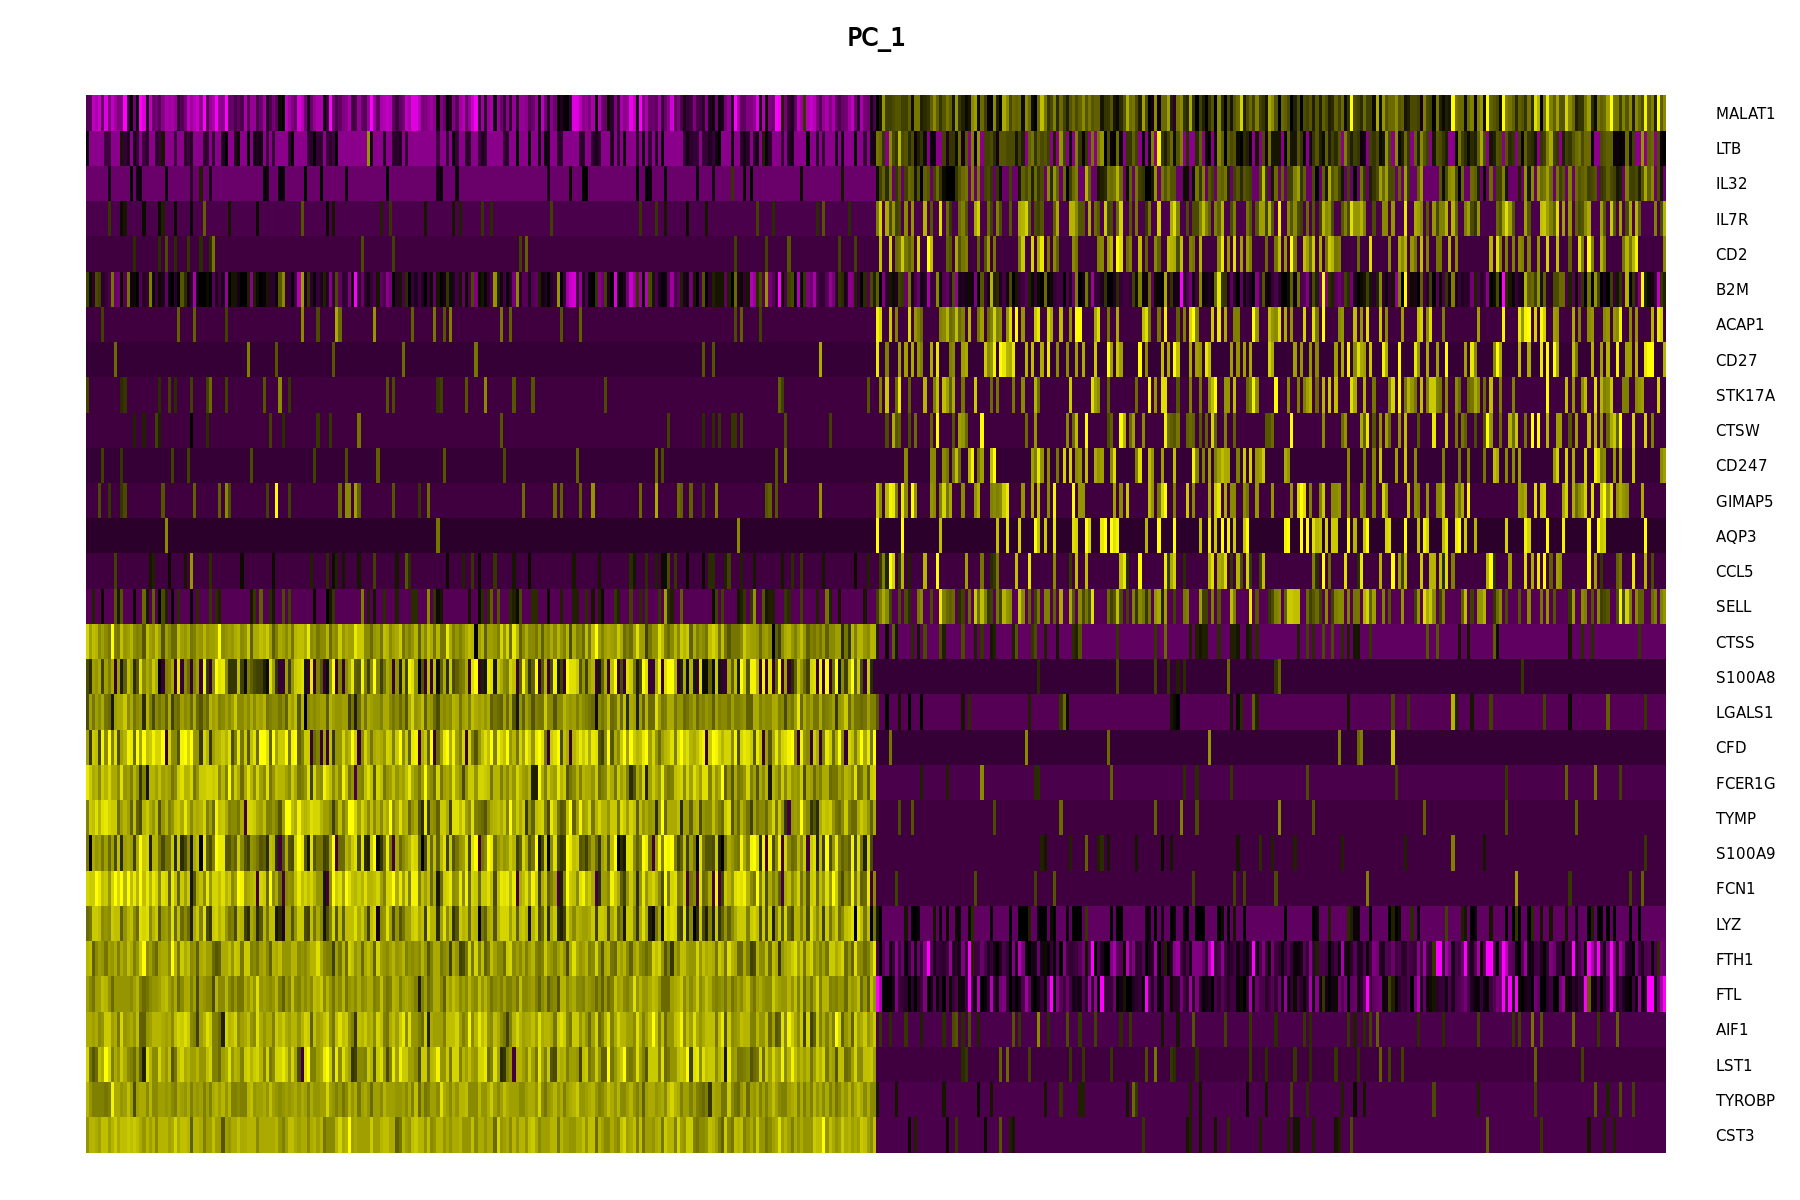

In [24]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

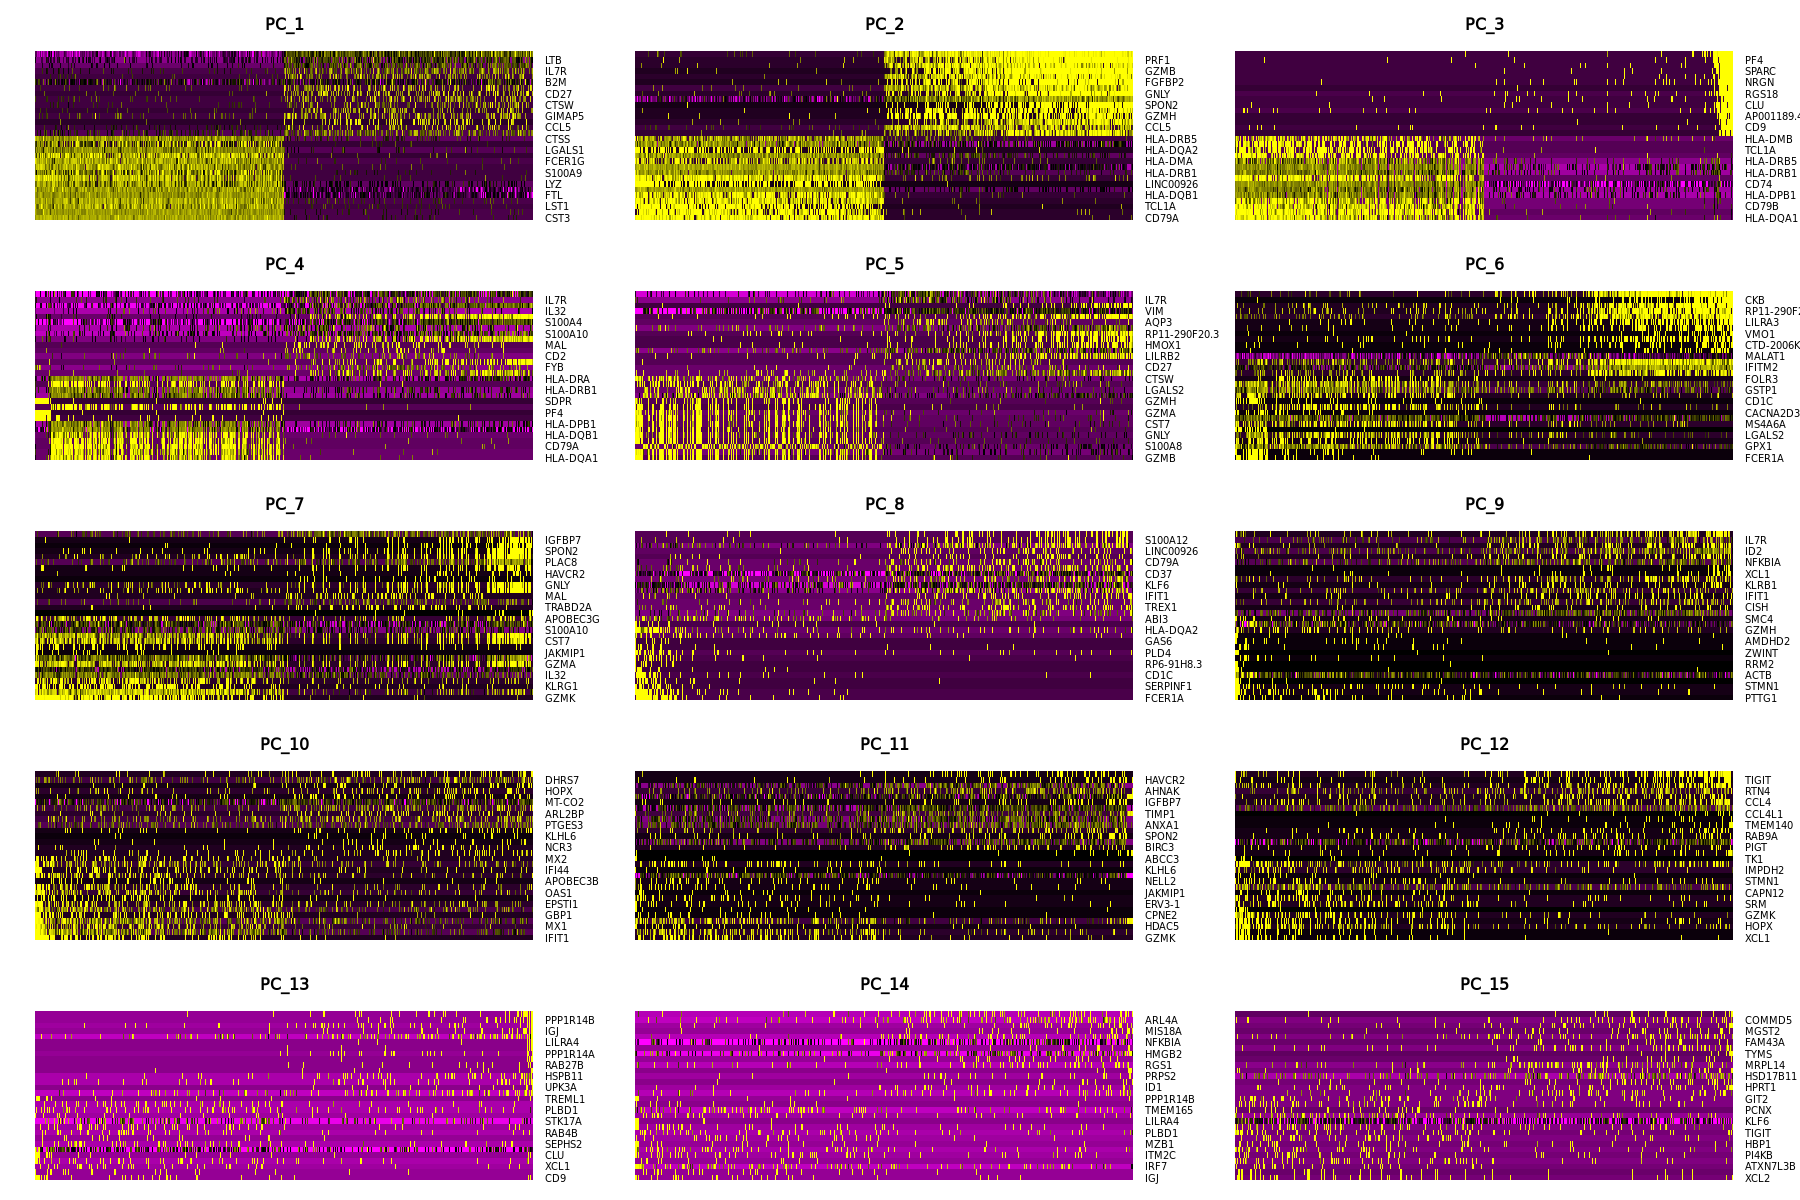

In [25]:
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

## Determine the 'dimensionality' of the dataset

In [26]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More
# approximate techniques such as those implemented in ElbowPlot() can be used to reduce
# computation time
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

Warning message:
“Removed 23501 rows containing missing values (`geom_point()`).”


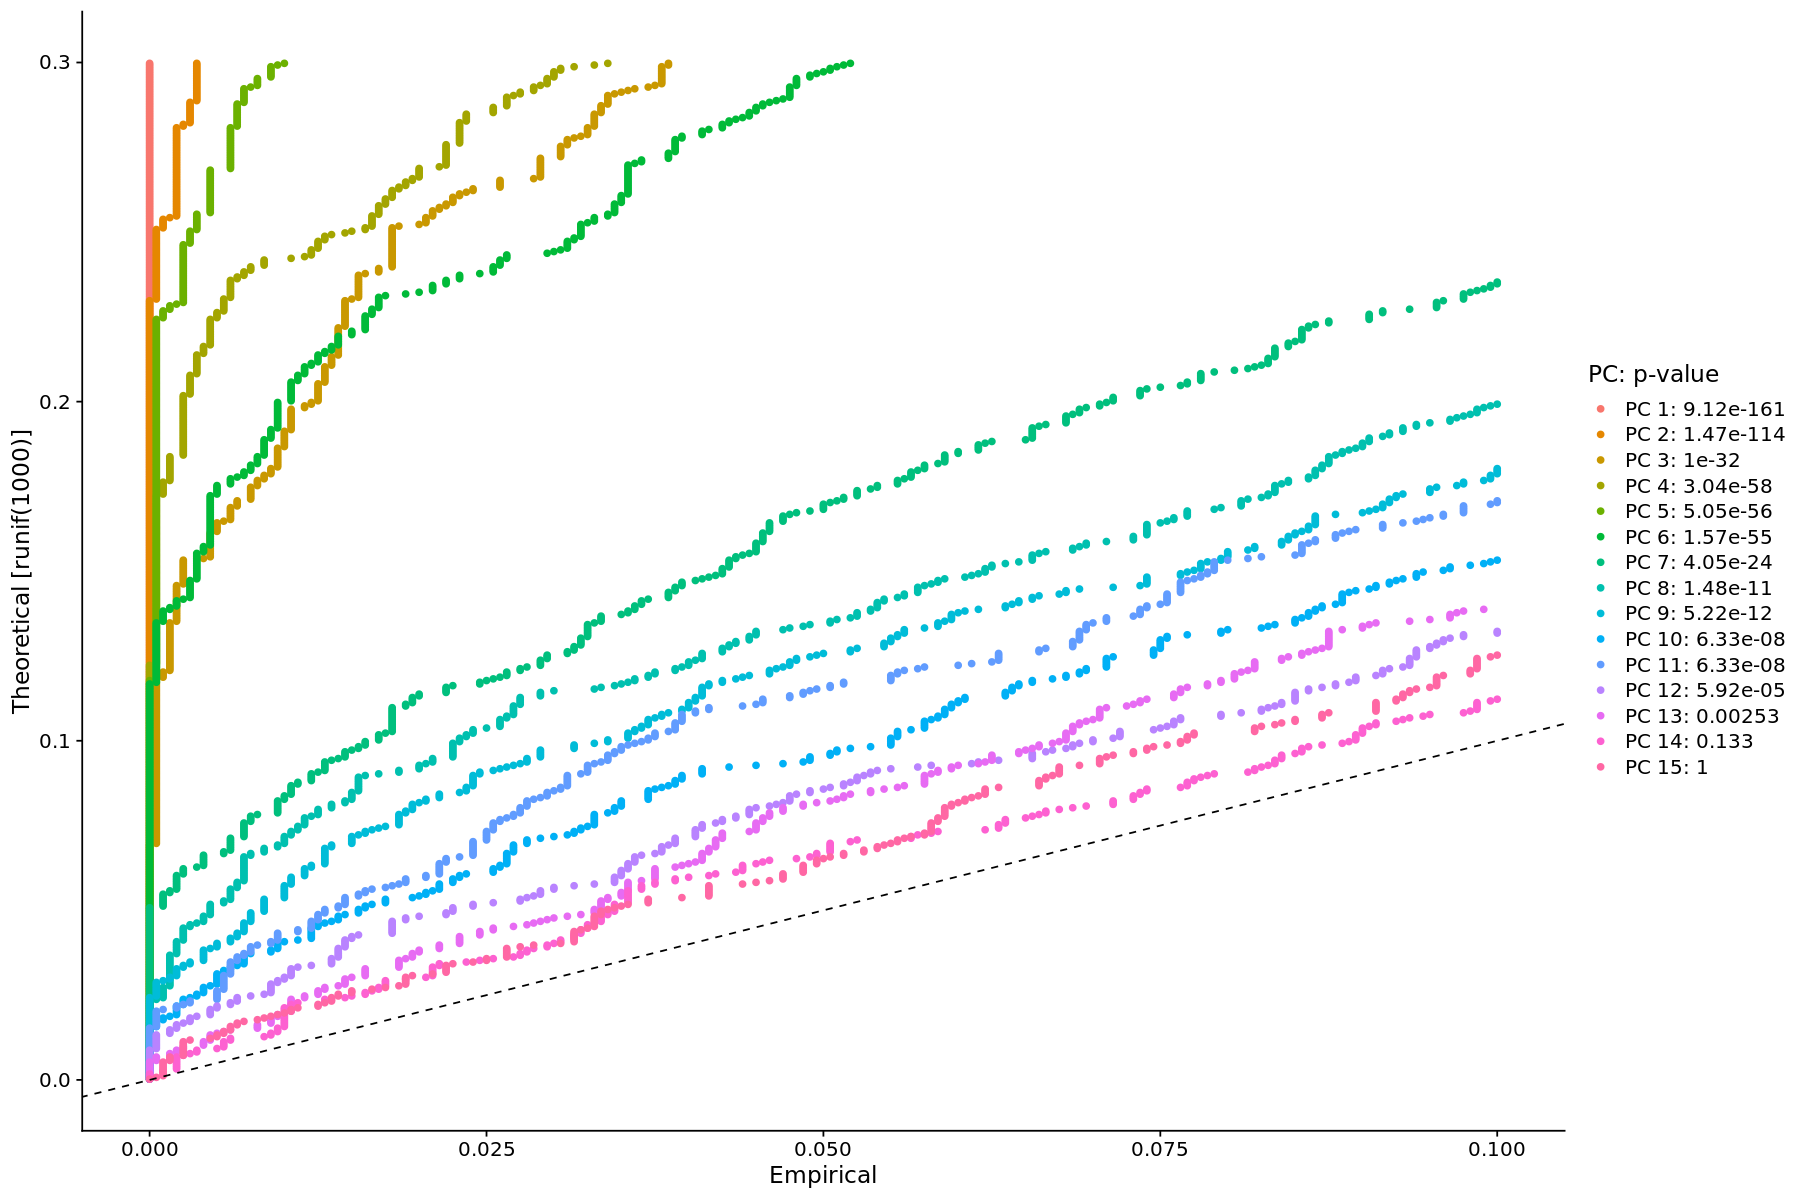

In [27]:
JackStrawPlot(pbmc, dims = 1:15)

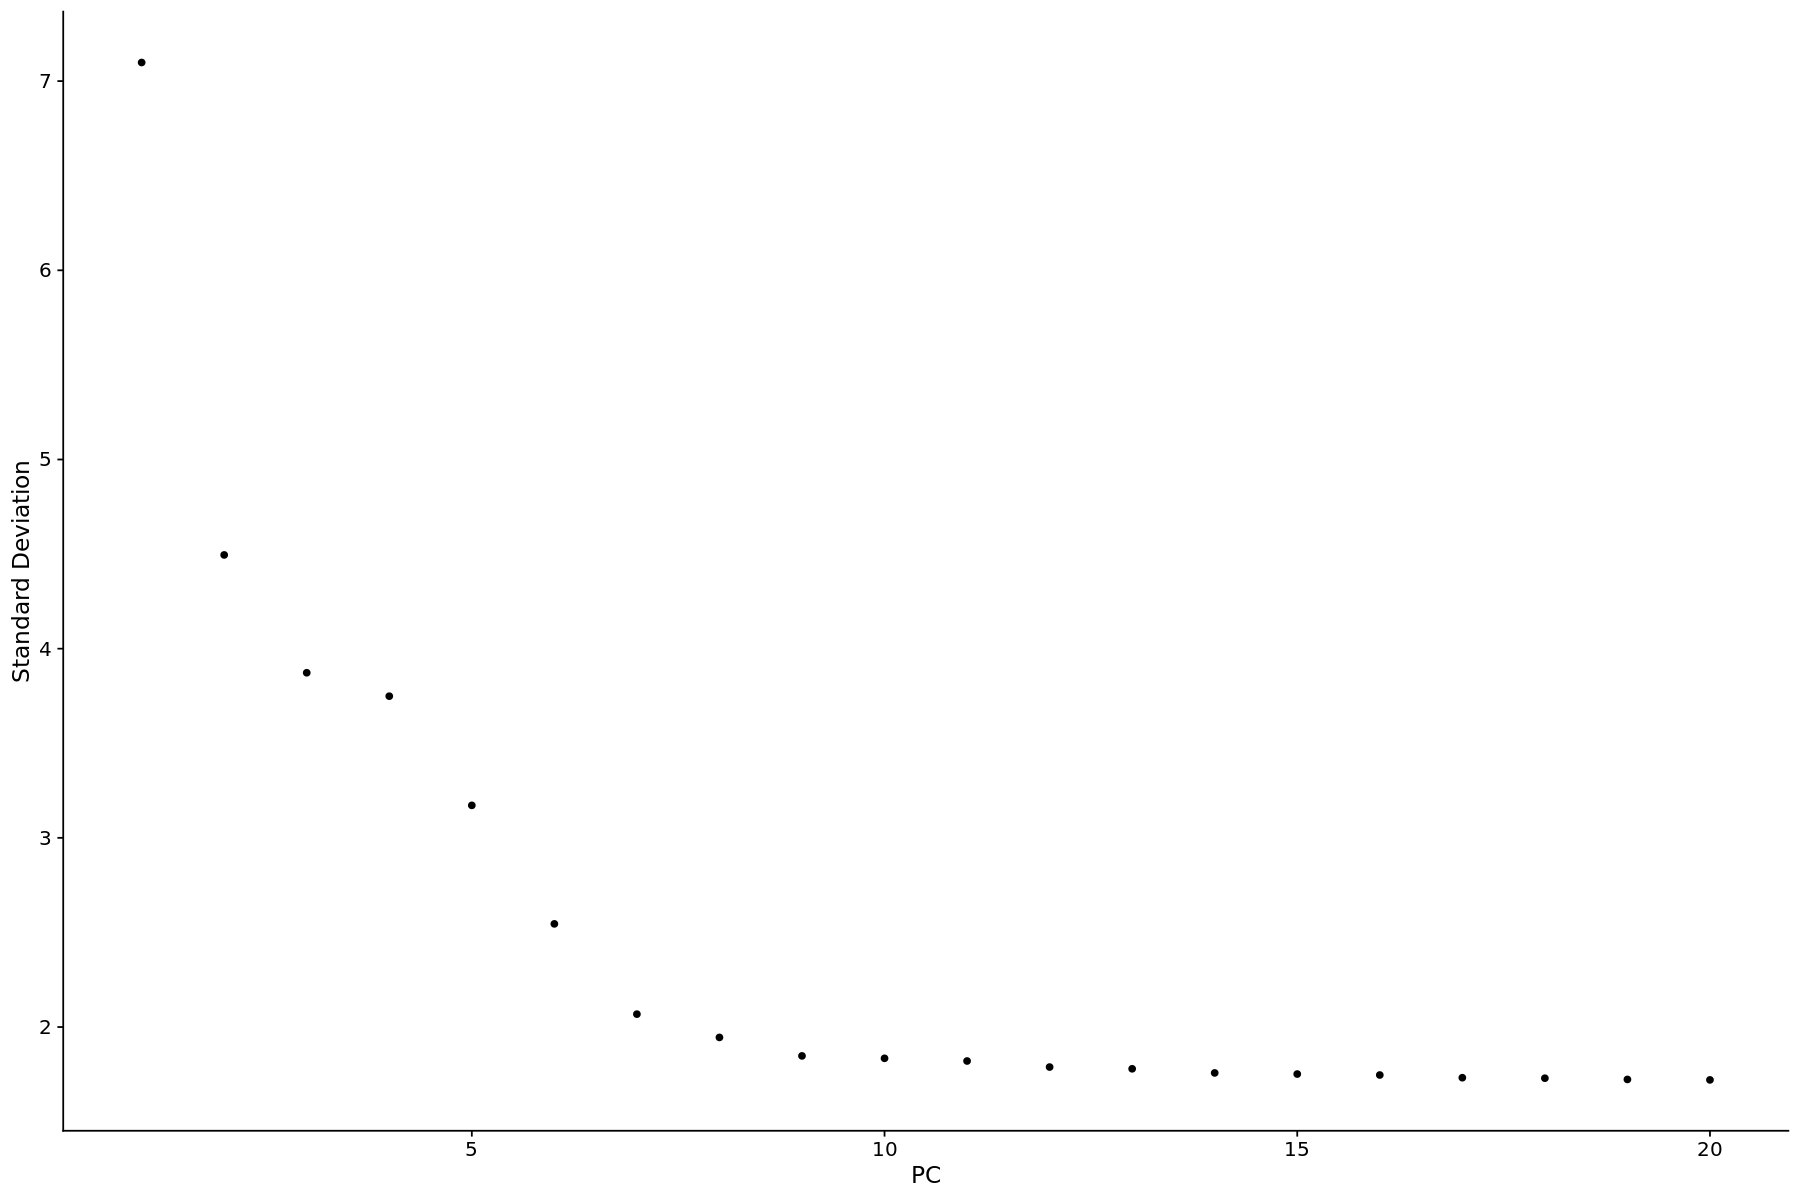

In [28]:
ElbowPlot(pbmc)

## Cluster the cells

In [29]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8723
Number of communities: 9
Elapsed time: 0 seconds


In [30]:
# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               2                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

## Run non-linear dimensional reduction (UMAP/tSNE)

In [31]:
# If you haven't installed UMAP, you can do so via reticulate::py_install(packages =
# 'umap-learn')
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:56:49 UMAP embedding parameters a = 0.9922 b = 1.112

10:56:49 Read 2638 rows and found 10 numeric columns

10:56:49 Using Annoy for neighbor search, n_neighbors = 30

10:56:49 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

10:56:49 Writing NN index file to temp file /tmp/RtmpKg4si9/filee5c51602d05

10:56:49 Searching Annoy index using 1 thread, search_k = 3000

10:56:50 Annoy recall = 100%

10:56:50 Commencing smooth kNN distance calibration using 1 thread
 with target n_neighbors = 

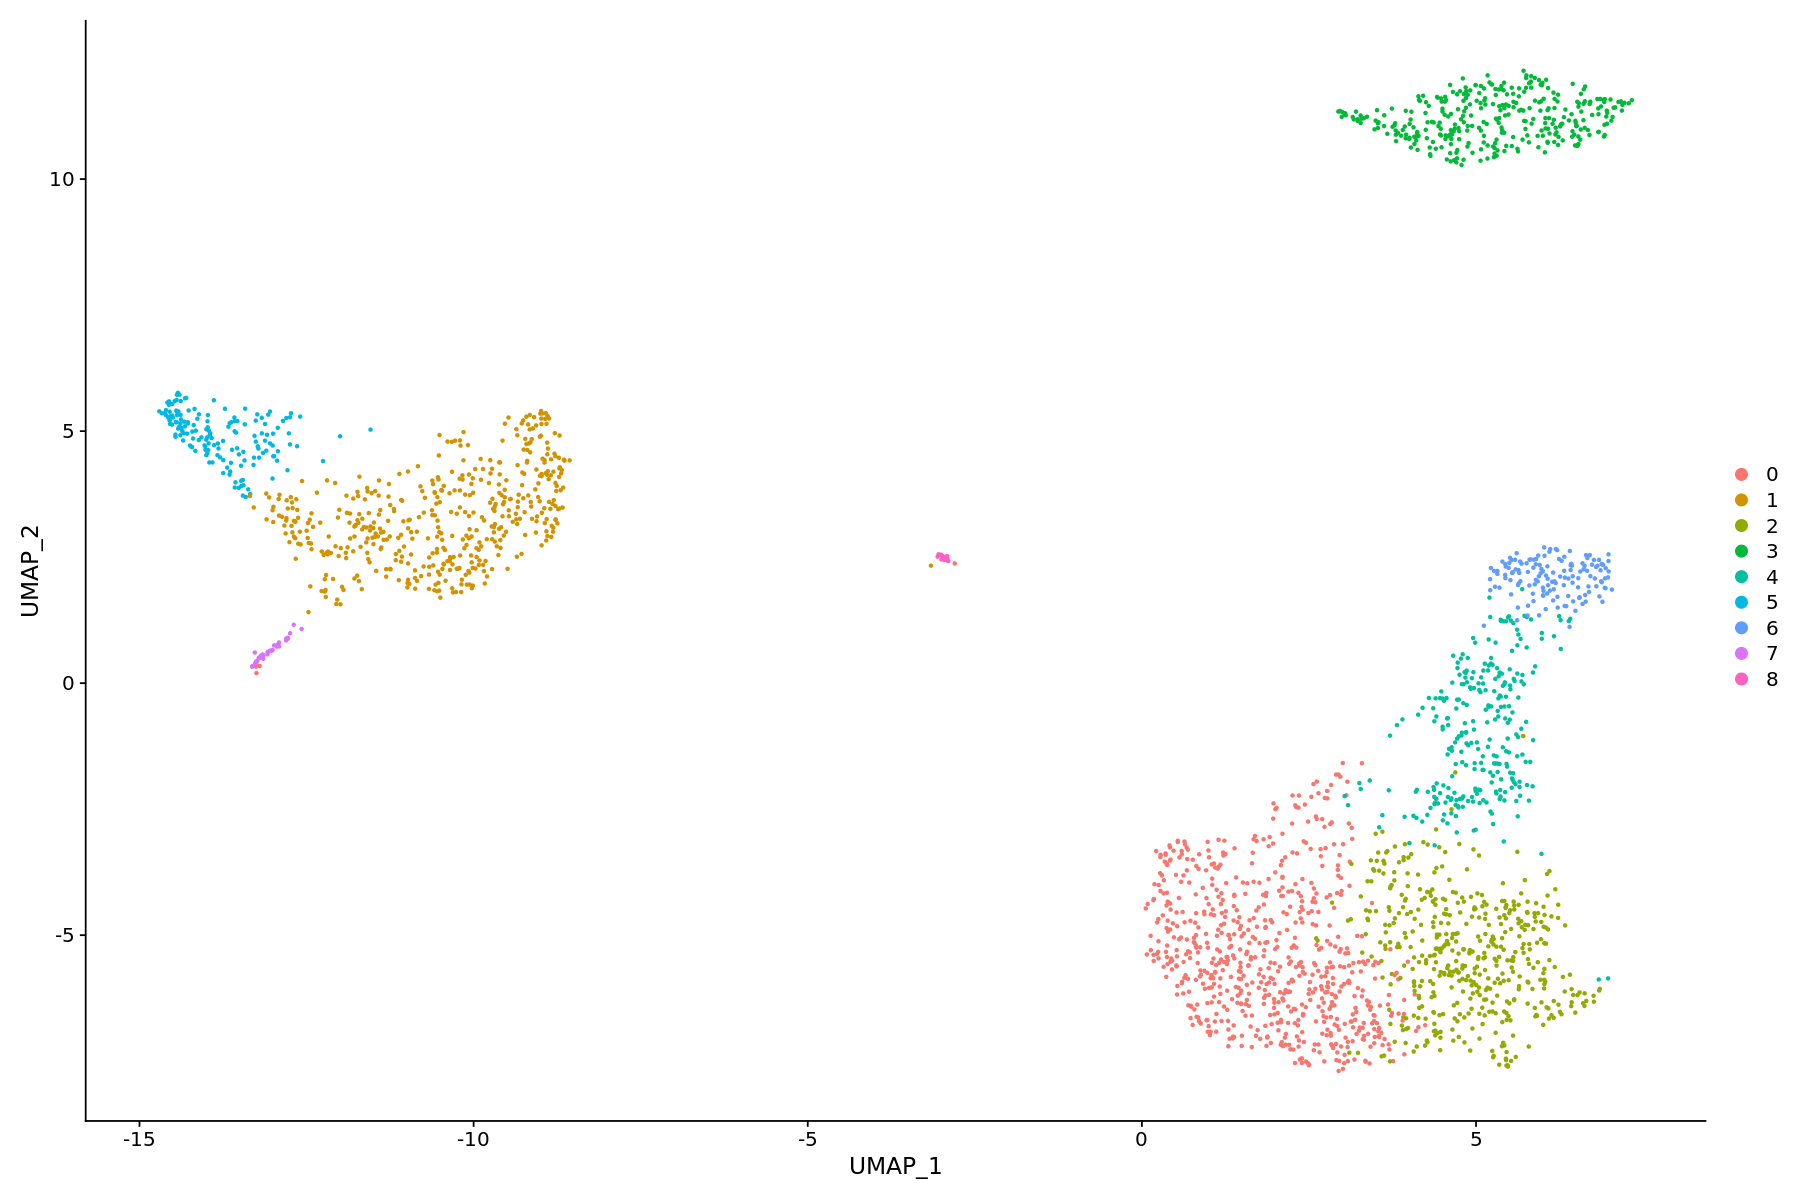

In [32]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label
# individual clusters
DimPlot(pbmc, reduction = "umap")

In [33]:
dir.create("pbmc_tutorial")

Warning message in dir.create("pbmc_tutorial"):
“'pbmc_tutorial' already exists”


In [34]:
saveRDS(pbmc, file = "./pbmc_tutorial/pbmc_tutorial.rds")

## Finding differentially expressed features (cluster biomarkers)

In [35]:
# find all markers of cluster 2
cluster2.markers <- FindMarkers(pbmc, ident.1 = 2, min.pct = 0.25)
head(cluster2.markers, n = 5)

For a more efficient implementation of the Wilcoxon Rank Sum Test,
(default method for FindMarkers) please install the limma package
--------------------------------------------
install.packages('BiocManager')
BiocManager::install('limma')
--------------------------------------------
After installation of limma, Seurat will automatically use the more 
efficient implementation (no further action necessary).
This message will be shown once per session



p_val        avg_log2FC pct.1 pct.2 p_val_adj   
IL32 2.593535e-91 1.2154360  0.949 0.466 3.556774e-87
LTB  7.994465e-87 1.2828597  0.981 0.644 1.096361e-82
CD3D 3.922451e-70 0.9359210  0.922 0.433 5.379250e-66
IL7R 1.130870e-66 1.1776027  0.748 0.327 1.550876e-62
LDHB 4.082189e-65 0.8837324  0.953 0.614 5.598314e-61

In [36]:
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)

p_val         avg_log2FC pct.1 pct.2 p_val_adj    
FCGR3A        2.150929e-209 4.267579   0.975 0.039 2.949784e-205
IFITM3        6.103366e-199 3.877105   0.975 0.048 8.370156e-195
CFD           8.891428e-198 3.411039   0.938 0.037 1.219370e-193
CD68          2.374425e-194 3.014535   0.926 0.035 3.256286e-190
RP11-290F20.3 9.308287e-191 2.722684   0.840 0.016 1.276538e-186

In [37]:
# find markers for every cluster compared to all remaining cells, report only the positive
# ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>%
    group_by(cluster) %>%
    slice_max(n = 2, order_by = avg_log2FC)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val         avg_log2FC pct.1 pct.2 p_val_adj     cluster gene    
1   1.167632e-83 1.333503   0.435 0.108  1.601290e-79 0       CCR7    
2  1.740957e-109 1.069166   0.897 0.593 2.387549e-105 0       LDHB    
3   0.000000e+00 5.570063   0.996 0.215  0.000000e+00 1       S100A9  
4   0.000000e+00 5.477394   0.975 0.121  0.000000e+00 1       S100A8  
5   7.994465e-87 1.282860   0.981 0.644  1.096361e-82 2       LTB     
6   2.610017e-59 1.240361   0.424 0.111  3.579377e-55 2       AQP3    
7   0.000000e+00 4.310172   0.936 0.041  0.000000e+00 3       CD79A   
8  9.481783e-271 3.591579   0.622 0.022 1.300332e-266 3       TCL1A   
9  4.932509e-169 3.006739   0.595 0.056 6.764443e-165 4       GZMK    
10 1.167095e-178 2.966206   0.957 0.241 1.600553e-174 4       CCL5    
11 3.511192e-184 3.311697   0.975 0.134 4.815249e-180 5       FCGR3A  
12 2.025672e-125 3.085654   1.000 0.315 2.778007e-121 5       LST1    
13 6.823265e-175 4.917370   0.958 0.135 9.357425e-171 6       GNLY    
14 1.051911e-265 4.888172   0.986 0.071 1.442590e-261 6       GZMB    
15 1.480764e-220 3.871151   0.812 0.011 2.030720e-216 7       FCER1A  
16  1.665286e-21 2.874465   1.000 0.513  2.283773e-17 7       HLA-DPB1
17 3.684548e-110 8.575862   1.000 0.024 5.052989e-106 8       PPBP    
18 7.731180e-200 7.243377   1.000 0.010 1.060254e-195 8       PF4

In [38]:
cluster0.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

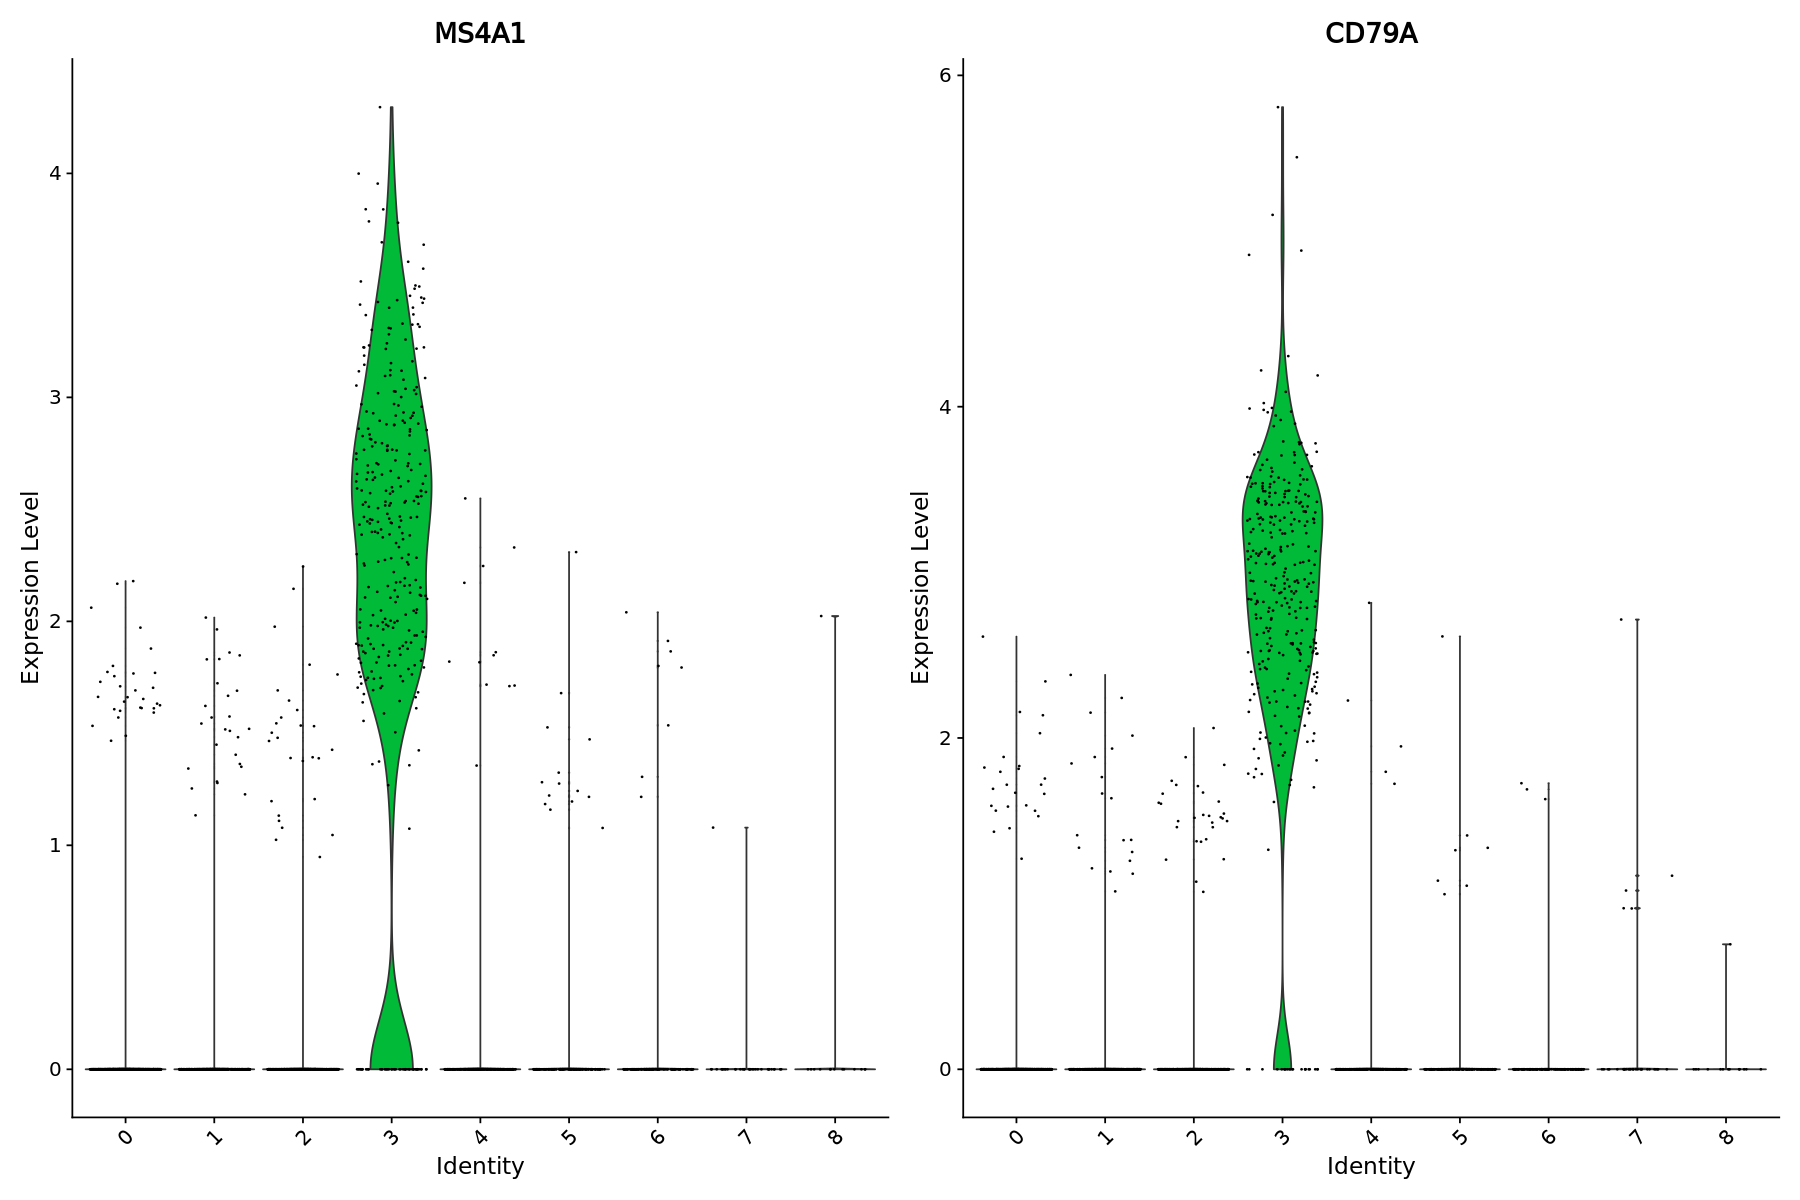

In [39]:
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))

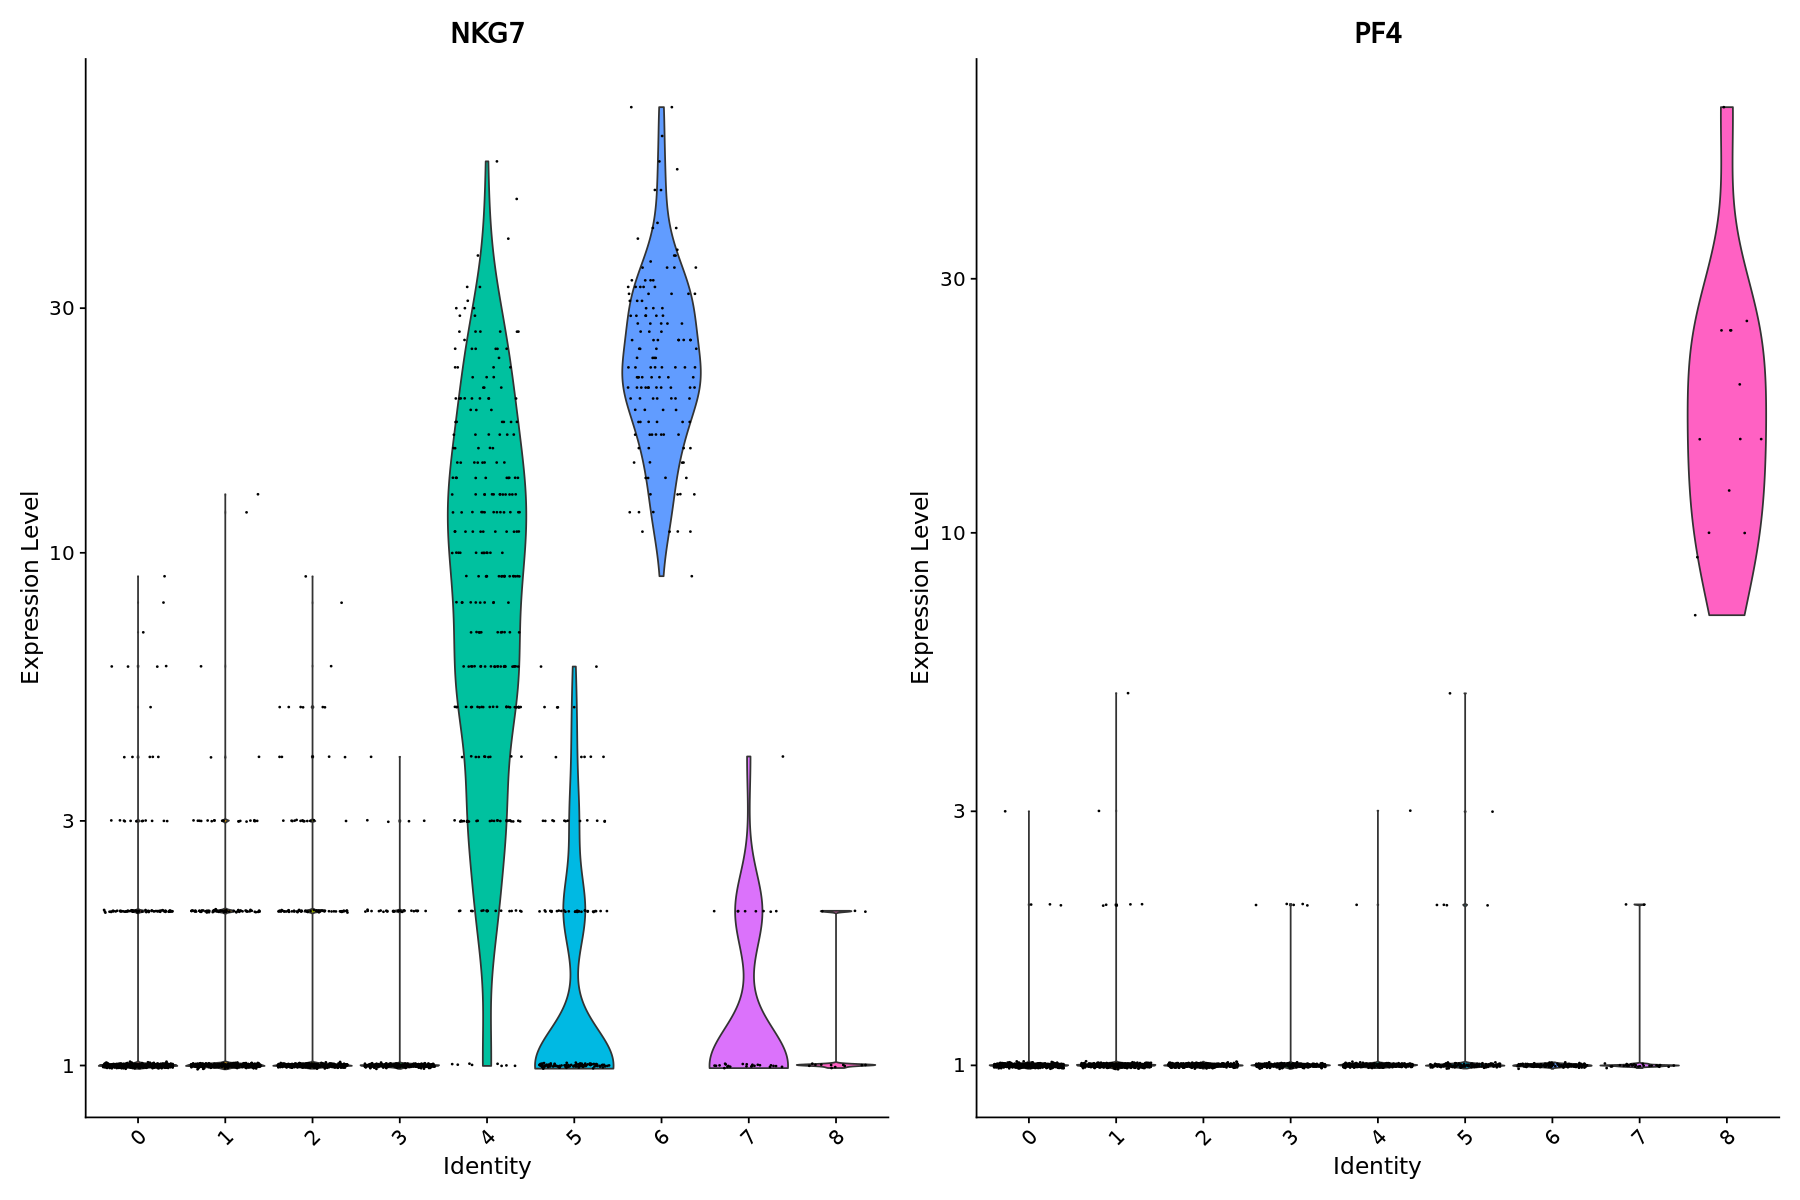

In [40]:
# you can plot raw counts as well
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = "counts", log = TRUE)

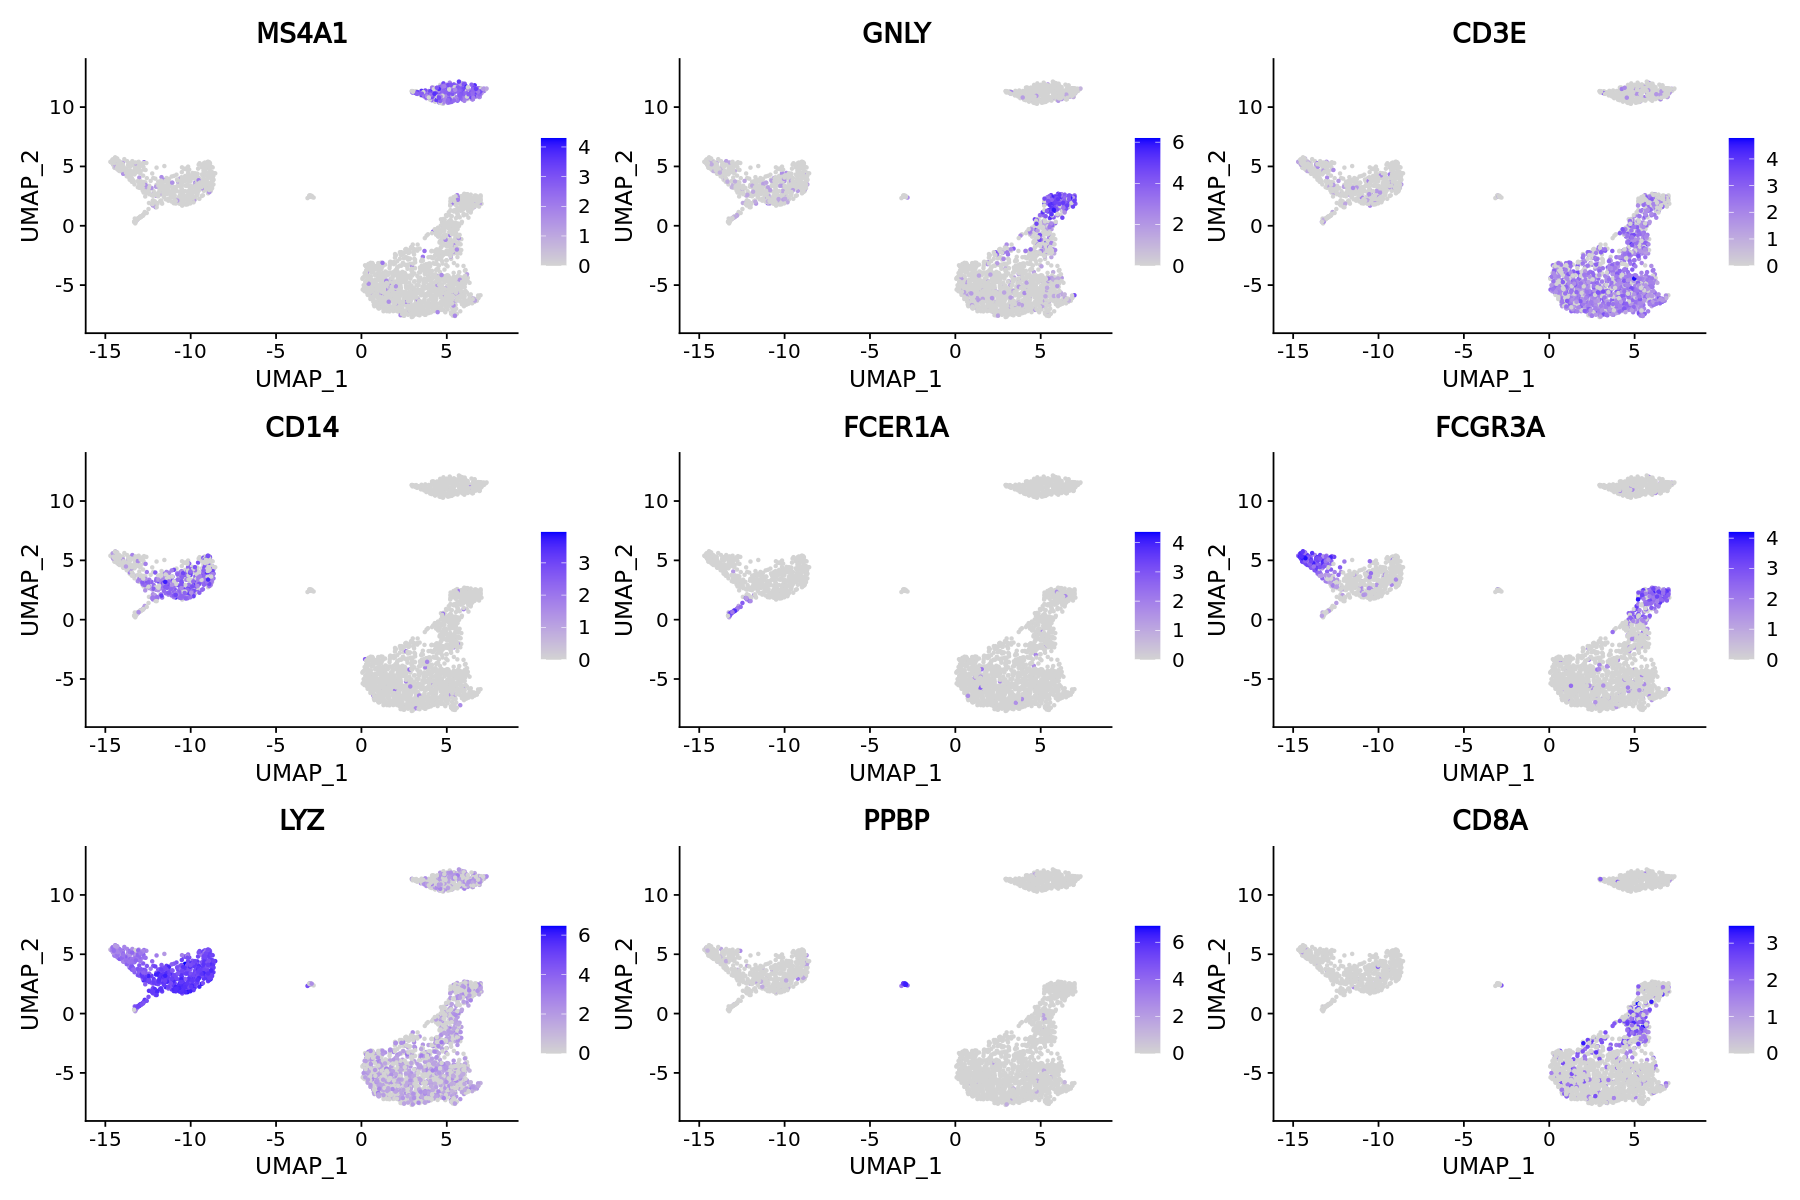

In [41]:
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP",
    "CD8A"))

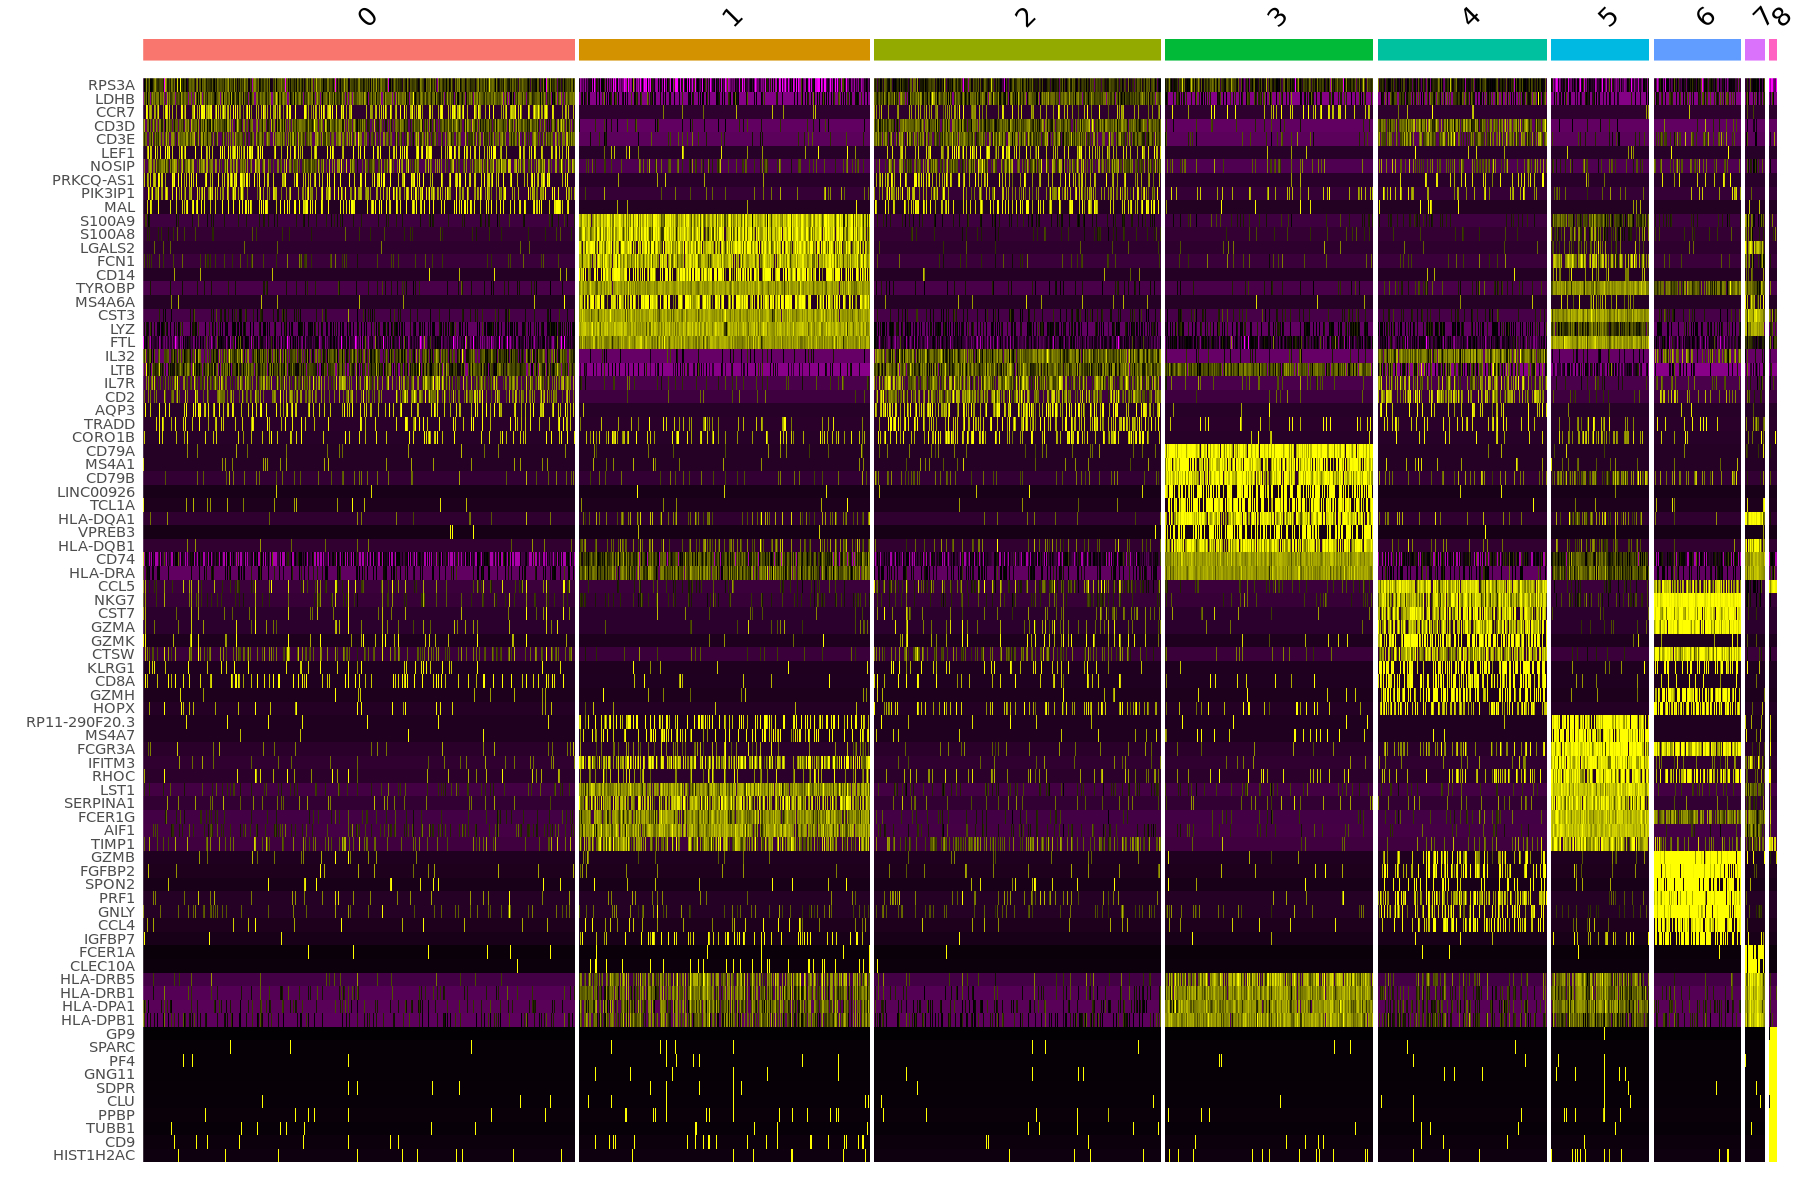

In [42]:
pbmc.markers %>%
    group_by(cluster) %>%
    top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

In [43]:
sessionInfo()

R version 4.3.1 (2023-06-16)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Debian GNU/Linux 11 (bullseye)

Matrix products: default
BLAS:   /opt/conda/lib/libblas.so.3.9.0 
LAPACK: /opt/conda/lib/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=C.UTF-8       LC_NUMERIC=C           LC_TIME=C.UTF-8       
 [4] LC_COLLATE=C.UTF-8     LC_MONETARY=C.UTF-8    LC_MESSAGES=C.UTF-8   
 [7] LC_PAPER=C.UTF-8       LC_NAME=C              LC_ADDRESS=C          
[10] LC_TELEPHONE=C         LC_MEASUREMENT=C.UTF-8 LC_IDENTIFICATION=C   

time zone: Etc/UTC
tzcode source: system (glibc)

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.4.3      patchwork_1.1.3    SeuratObject_4.1.3 Seurat_4.3.0.1    
[5] dplyr_1.1.3       

loaded via a namespace (and not attached):
  [1] deldir_1.0-9           pbapply_1.7-2          gridExtra_2.3         
  [4] rlang_1.1.1            magrittr_2.0.3         RcppAnnoy_0.0.21    